In [1]:
import numpy as np
import math 
import pandas as pd
from pandas.io.json import json_normalize
import json
from genson import SchemaBuilder
import sys  
sys.path.insert(0, './scripts')
from PricingModels import *

def calc_x_reserves(APY,y_reserves,days_until_maturity,time_stretch):
  t=days_until_maturity/(365*time_stretch)
  T=days_until_maturity/365
  return y_reserves/((1-T*(APY/100))**(-1/t)-1)



trades = []
run_matrix=[]
cols = ["init.apy","init.percent_fee","init.days_until_maturity","init.max_order_size","init.time_stretch",\
        "init.market_price","init.target_liquidity","init.target_daily_volume","input.day","input.time",\
        "input.base_market_price", "input.unit_fyt_price","input.base_reserves","input.fyt_reserves",\
        "input.token_in","input.amount_specified","input.token_out","input.direction",\
        "output.trade_volume","output.fee","output.slippage"]

ybas = [
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 40,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 30,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 1.7,
        "market_price" : 50000,
        "time_stretch": 20,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 40,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 30,
        "days_until_maturity": 180,
    },
    {
        "vault" : "yWBTC",
        "apy" : 3,
        "market_price" : 50000,
        "time_stretch": 20,
        "days_until_maturity": 180,
    },
    {
        "vault" : "ycrvSTETH",
        "apy" : 20,
        "market_price" : 1500,
        "time_stretch": 5,
        "days_until_maturity": 90,
    },
]


for target_daily_volume in [5000000,10000000]:
    for target_liquidity in [5000000]:
        for g in [.1]:
                for yba in ybas:
                    np.random.seed(2)
                    APY=yba["apy"]
                    days_until_maturity = yba["days_until_maturity"]
                    market_price = yba["market_price"]
                    time_stretch = yba["time_stretch"]
                    run_matrix.append((yba,g,target_liquidity,target_daily_volume))

                    y_start = target_liquidity/market_price
                    max_order_price=12500
                    max_order_size=max_order_price/market_price 
                    sigma=max_order_size/10


                    x_start = calc_x_reserves(APY,y_start,days_until_maturity,time_stretch)
                    total_supply=x_start
                    t=days_until_maturity/(365*time_stretch)

                    step_size=t/days_until_maturity
                    epsilon=step_size/2
                    m = Market(x_start,y_start,g,t,total_supply,Element_Pricing_Model)
                    print("Days Until Maturity: " + str(days_until_maturity))
                    print("Time Stretch: " + str(time_stretch))
                    print("Fee %: " + str(g*100))
                    print("Starting APY: {:.2f}%".format(m.apy(days_until_maturity)))
                    print("Starting FYT Price: " + str(m.fyt_price()))
                    print("Starting Liquidity: ${:,.2f}".format(x_start*market_price+y_start*market_price))
                    print("Starting Base Reserves: " + str(m.x))
                    print("Starting FYT Reserves: " + str(m.y))
                    x_orders=0
                    x_volume=0
                    y_orders=0
                    y_volume=0

                    total_fees = 0
                    todays_volume = 0
                    todays_fees = 0
                    todays_num_trades = 0
                    day=0
                    while m.t > epsilon:
                        day += 1
                        todays_volume = 0
                        todays_fees = 0
                        todays_num_trades = 0
                        maturity_ratio = day/days_until_maturity
                        ub=target_daily_volume*math.log10(1/maturity_ratio) # log(1/maturity ratio) is used to simulate waning demand over the lifetime of the fyt
                        todays_target_volume = np.random.uniform(ub/2,ub)
                        while todays_target_volume > todays_volume:
                            fee = -1
                            trade = []
                            while fee < 0:
                                # determine order size
                                amount = np.random.normal(max_order_size/2,sigma)
                                lb_amount = max(0.00001,amount)
                                amount = min(max_order_size,lb_amount)
                                # buy fyt or base
                                if np.random.uniform(0,1) < 0.5:
                                    token_in = "base"
                                    token_out = "fyt"
                                else:
                                    token_in = "fyt"
                                    token_out = "base"

                                if np.random.uniform(0,1) < 0.5:
                                    direction="in"
                                else:
                                    direction="out"
                                    

                                start_x_volume = m.x_volume
                                start_y_volume = m.y_volume
                                (without_fee_or_slippage,with_fee,without_fee,fee) = m.swap(amount,direction,token_in,token_out)
                                
                                trade = [APY,g,days_until_maturity,max_order_size,time_stretch,market_price,target_liquidity,target_daily_volume,day,m.t,market_price,m.fyt_price(),m.x,m.y,token_in,amount,token_out,direction,with_fee*market_price,fee*market_price,(without_fee_or_slippage-without_fee)*market_price]
                                
                            trades.append(trade);
                            todays_volume += (m.x_volume - start_x_volume)*market_price + (m.y_volume - start_y_volume)*market_price
                            todays_fees += fee*market_price
                            todays_num_trades += 1
                        print("\tDay: " + str(day) + " FYT Price: " + str(m.fyt_price()) + " Implied APY: " + str(m.apy(days_until_maturity-day+1)) + " Target Volume Factor: {:,.4f}".format(math.log10(1/maturity_ratio)) + " Volume: ${:,.2f}".format(todays_volume) + " Num Trades: " + str(todays_num_trades) + " Fees: ${:,.2f}".format(todays_fees))
                        total_fees += todays_fees
                        m.tick(step_size)

                    print("Ending Liquidity: ${:,.2f}".format(m.x*market_price+m.y*market_price))
                    print("Total volume: ${:,.2f}".format(m.x_volume*market_price+m.y_volume*market_price))
                    print("Total fees: ${:,.2f}".format(total_fees))
                    print("Ending Base Reserves: " + str(m.x))
                    print("Delta Base Reserves: " + str(abs(x_start-m.x)))
                    print("Ending FYT Reserves: " + str(m.y))
                    print("Delta FYT Reserves: " + str(abs(y_start-m.y)))
                    print("Num base orders: " + str(m.x_orders))
                    print("Cum base volume: " + str(m.x_volume))
                    print("Num FYT orders: " + str(m.y_orders))
                    print("Cum FYT volume: " + str(m.y_volume))
                    print("Cum slippage Base: " + str(m.cum_x_slippage))
                    print("Cum slippage FYT: " + str(m.cum_y_slippage))
                    print("Cum fees Base: " + str(m.cum_x_fees))
                    print("Cum fees FYT: " + str(m.cum_y_fees))
                    print("Ending FYT Price: " + str(m.fyt_price()))
                    print("Ending Time: " + str(m.t))
                    print("##################################################################")



#df = pd.DataFrame.from_dict(json_normalize(trades), orient='columns')
df = pd.DataFrame(trades,columns=cols)




Days Until Maturity: 180
Time Stretch: 40
Fee %: 10.0
Starting APY: 1.70%
Starting FYT Price: 0.9916164383561644
Starting Liquidity: $10,104,416.68
Starting Base Reserves: 102.0883335589536
Starting FYT Reserves: 100.0
	Day: 1 FYT Price: 0.9907018427776642 Implied APY: 1.8854596589736576 Target Volume Factor: 2.2553 Volume: $8,101,701.79 Num Trades: 1306 Fees: $7,165.92
	Day: 2 FYT Price: 0.9916221948010377 Implied APY: 1.7083234064923027 Target Volume Factor: 1.9542 Volume: $5,721,403.33 Num Trades: 921 Fees: $5,014.75
	Day: 3 FYT Price: 0.99206151080111 Implied APY: 1.627836268311704 Target Volume Factor: 1.7782 Volume: $5,419,788.32 Num Trades: 871 Fees: $4,389.45
	Day: 4 FYT Price: 0.9915394253403801 Implied APY: 1.7446947744413945 Target Volume Factor: 1.6532 Volume: $7,823,702.85 Num Trades: 1248 Fees: $6,647.30
	Day: 5 FYT Price: 0.9916916530209818 Implied APY: 1.7230378678077445 Target Volume Factor: 1.5563 Volume: $6,109,257.22 Num Trades: 976 Fees: $5,095.93
	Day: 6 FYT Price

	Day: 98 FYT Price: 0.9988228757333109 Implied APY: 0.5176510329416117 Target Volume Factor: 0.2640 Volume: $715,324.66 Num Trades: 120 Fees: $83.56
	Day: 99 FYT Price: 0.9987455963939625 Implied APY: 0.5583625807361854 Target Volume Factor: 0.2596 Volume: $756,145.00 Num Trades: 121 Fees: $91.95
	Day: 100 FYT Price: 0.9988348339170053 Implied APY: 0.525043975670434 Target Volume Factor: 0.2553 Volume: $912,862.64 Num Trades: 145 Fees: $106.73
	Day: 101 FYT Price: 0.9987856417236345 Implied APY: 0.5540509635917651 Target Volume Factor: 0.2510 Volume: $1,153,222.62 Num Trades: 179 Fees: $132.79
	Day: 102 FYT Price: 0.9988107608522981 Implied APY: 0.5494585935584541 Target Volume Factor: 0.2467 Volume: $1,188,112.96 Num Trades: 193 Fees: $143.36
	Day: 103 FYT Price: 0.9989152854704436 Implied APY: 0.5075907734462572 Target Volume Factor: 0.2424 Volume: $1,099,660.59 Num Trades: 174 Fees: $121.97
	Day: 104 FYT Price: 0.9989118609447678 Implied APY: 0.5158061755321447 Target Volume Factor:

	Day: 6 FYT Price: 0.9915591289581053 Implied APY: 1.760524531595186 Target Volume Factor: 1.4771 Volume: $3,997,775.18 Num Trades: 632 Fees: $3,259.40
	Day: 7 FYT Price: 0.9917858995316368 Implied APY: 1.7230727993980357 Target Volume Factor: 1.4102 Volume: $4,342,726.68 Num Trades: 685 Fees: $3,631.11
	Day: 8 FYT Price: 0.9918560570649901 Implied APY: 1.7182307348431212 Target Volume Factor: 1.3522 Volume: $4,298,141.45 Num Trades: 691 Fees: $3,490.08
	Day: 9 FYT Price: 0.9905657390222465 Implied APY: 2.0020379400465194 Target Volume Factor: 1.3010 Volume: $6,091,619.37 Num Trades: 977 Fees: $5,240.09
	Day: 10 FYT Price: 0.9905293272066769 Implied APY: 2.021517876937396 Target Volume Factor: 1.2553 Volume: $4,305,625.25 Num Trades: 692 Fees: $4,003.49
	Day: 11 FYT Price: 0.9903293293246161 Implied APY: 2.076349880303004 Target Volume Factor: 1.2139 Volume: $5,816,742.52 Num Trades: 933 Fees: $5,574.34
	Day: 12 FYT Price: 0.9906794184064006 Implied APY: 2.0130250187359624 Target Volum

	Day: 62 FYT Price: 0.9968293783180773 Implied APY: 0.9725016083208358 Target Volume Factor: 0.4629 Volume: $2,094,986.12 Num Trades: 337 Fees: $620.71
	Day: 63 FYT Price: 0.9972496067453444 Implied APY: 0.850757235550264 Target Volume Factor: 0.4559 Volume: $1,714,502.97 Num Trades: 279 Fees: $522.51
	Day: 64 FYT Price: 0.9973555273437578 Implied APY: 0.8249850594259968 Target Volume Factor: 0.4491 Volume: $2,160,015.40 Num Trades: 345 Fees: $626.09
	Day: 65 FYT Price: 0.9974520673672141 Implied APY: 0.8017201818679628 Target Volume Factor: 0.4424 Volume: $1,717,327.80 Num Trades: 278 Fees: $434.18
	Day: 66 FYT Price: 0.9971804240351338 Implied APY: 0.8949088931966477 Target Volume Factor: 0.4357 Volume: $1,904,663.49 Num Trades: 309 Fees: $522.10
	Day: 67 FYT Price: 0.9971037200133035 Implied APY: 0.927317715038793 Target Volume Factor: 0.4292 Volume: $1,178,652.67 Num Trades: 188 Fees: $335.66
	Day: 68 FYT Price: 0.9972423076622389 Implied APY: 0.8907590294538165 Target Volume Facto

	Day: 2 FYT Price: 0.9916250365268545 Implied APY: 1.707743948434693 Target Volume Factor: 1.9542 Volume: $5,721,402.03 Num Trades: 921 Fees: $5,000.71
	Day: 3 FYT Price: 0.9920442351689572 Implied APY: 1.631378743444163 Target Volume Factor: 1.7782 Volume: $5,419,791.50 Num Trades: 871 Fees: $4,395.17
	Day: 4 FYT Price: 0.9915532700364149 Implied APY: 1.7418397947505968 Target Volume Factor: 1.6532 Volume: $7,823,693.25 Num Trades: 1248 Fees: $6,635.48
	Day: 5 FYT Price: 0.9916992455080836 Implied APY: 1.7214632895167454 Target Volume Factor: 1.5563 Volume: $6,109,256.65 Num Trades: 976 Fees: $5,091.18
	Day: 6 FYT Price: 0.991566967069503 Implied APY: 1.7588897255036644 Target Volume Factor: 1.4771 Volume: $3,997,775.39 Num Trades: 632 Fees: $3,259.43
	Day: 7 FYT Price: 0.9917889689577726 Implied APY: 1.722428925524718 Target Volume Factor: 1.4102 Volume: $4,342,727.50 Num Trades: 685 Fees: $3,628.45
	Day: 8 FYT Price: 0.9918585774426822 Implied APY: 1.7176989788560586 Target Volume F

	Day: 68 FYT Price: 0.9972187030714396 Implied APY: 0.8983835211721772 Target Volume Factor: 0.4228 Volume: $1,541,030.54 Num Trades: 248 Fees: $432.37
	Day: 69 FYT Price: 0.9971023791199565 Implied APY: 0.9443139475141853 Target Volume Factor: 0.4164 Volume: $1,332,584.81 Num Trades: 217 Fees: $374.53
	Day: 70 FYT Price: 0.9971192188417443 Implied APY: 0.9472838943813922 Target Volume Factor: 0.4102 Volume: $1,718,324.17 Num Trades: 281 Fees: $502.12
	Day: 71 FYT Price: 0.9973253995302411 Implied APY: 0.8874810649654433 Target Volume Factor: 0.4040 Volume: $1,075,745.06 Num Trades: 176 Fees: $299.57
	Day: 72 FYT Price: 0.9974942909336226 Implied APY: 0.8390677148878352 Target Volume Factor: 0.3979 Volume: $1,251,629.43 Num Trades: 201 Fees: $315.11
	Day: 73 FYT Price: 0.9977600641272083 Implied APY: 0.7570153644157129 Target Volume Factor: 0.3919 Volume: $1,401,647.76 Num Trades: 228 Fees: $324.78
	Day: 74 FYT Price: 0.9978467534997668 Implied APY: 0.7345186659673951 Target Volume Fac

	Day: 144 FYT Price: 0.9990995357058969 Implied APY: 0.8882958576962668 Target Volume Factor: 0.0969 Volume: $482,471.90 Num Trades: 77 Fees: $43.29
	Day: 145 FYT Price: 0.9991153960979657 Implied APY: 0.8968900673402959 Target Volume Factor: 0.0939 Volume: $449,126.77 Num Trades: 74 Fees: $40.03
	Day: 146 FYT Price: 0.9991670375146863 Implied APY: 0.8686608775414575 Target Volume Factor: 0.0909 Volume: $288,460.87 Num Trades: 46 Fees: $24.70
	Day: 147 FYT Price: 0.9992001127489051 Implied APY: 0.8587024901460188 Target Volume Factor: 0.0880 Volume: $371,000.42 Num Trades: 60 Fees: $28.99
	Day: 148 FYT Price: 0.9992052129750284 Implied APY: 0.8790826185291932 Target Volume Factor: 0.0850 Volume: $228,859.12 Num Trades: 37 Fees: $17.92
	Day: 149 FYT Price: 0.9991865063516464 Implied APY: 0.9278911926533153 Target Volume Factor: 0.0821 Volume: $328,810.77 Num Trades: 53 Fees: $25.73
	Day: 150 FYT Price: 0.9992739227596951 Implied APY: 0.8548973958429065 Target Volume Factor: 0.0792 Volum

	Day: 15 FYT Price: 0.9821284598179971 Implied APY: 3.9295856424283433 Target Volume Factor: 1.0792 Volume: $3,537,938.47 Num Trades: 569 Fees: $6,525.32
	Day: 16 FYT Price: 0.9844126365440782 Implied APY: 3.4481137341887664 Target Volume Factor: 1.0512 Volume: $3,558,978.63 Num Trades: 561 Fees: $5,985.82
	Day: 17 FYT Price: 0.9857018418069752 Implied APY: 3.182212036862232 Target Volume Factor: 1.0248 Volume: $3,339,510.78 Num Trades: 534 Fees: $5,103.37
	Day: 18 FYT Price: 0.9832510322395057 Implied APY: 3.750535725509456 Target Volume Factor: 1.0000 Volume: $3,015,389.33 Num Trades: 483 Fees: $4,774.40
	Day: 19 FYT Price: 0.984409847061903 Implied APY: 3.512596186669993 Target Volume Factor: 0.9765 Volume: $2,626,190.04 Num Trades: 424 Fees: $4,227.89
	Day: 20 FYT Price: 0.9859264000047103 Implied APY: 3.1905987566961067 Target Volume Factor: 0.9542 Volume: $4,695,597.85 Num Trades: 743 Fees: $7,023.92
	Day: 21 FYT Price: 0.9845731238528794 Implied APY: 3.5192561210618805 Target Vo

	Day: 129 FYT Price: 0.9965957622056343 Implied APY: 2.3895130671990126 Target Volume Factor: 0.1447 Volume: $378,401.85 Num Trades: 59 Fees: $126.03
	Day: 130 FYT Price: 0.9968009762174108 Implied APY: 2.2894974130295136 Target Volume Factor: 0.1413 Volume: $405,651.75 Num Trades: 65 Fees: $133.76
	Day: 131 FYT Price: 0.9968697142431459 Implied APY: 2.2851086025035263 Target Volume Factor: 0.1380 Volume: $552,260.75 Num Trades: 89 Fees: $177.06
	Day: 132 FYT Price: 0.9969067288704062 Implied APY: 2.3041713516361897 Target Volume Factor: 0.1347 Volume: $531,673.17 Num Trades: 88 Fees: $162.36
	Day: 133 FYT Price: 0.997002226708007 Implied APY: 2.2795567741196945 Target Volume Factor: 0.1314 Volume: $459,037.17 Num Trades: 74 Fees: $137.97
	Day: 134 FYT Price: 0.9970647074823936 Implied APY: 2.279535678566657 Target Volume Factor: 0.1282 Volume: $356,151.76 Num Trades: 55 Fees: $104.64
	Day: 135 FYT Price: 0.9971842467972923 Implied APY: 2.2342389543223824 Target Volume Factor: 0.1249 V

	Day: 15 FYT Price: 0.9827347569077454 Implied APY: 3.7962733305258687 Target Volume Factor: 1.0792 Volume: $3,537,855.93 Num Trades: 569 Fees: $6,277.83
	Day: 16 FYT Price: 0.9846561635030425 Implied APY: 3.3942426190239265 Target Volume Factor: 1.0512 Volume: $3,559,014.62 Num Trades: 561 Fees: $5,832.78
	Day: 17 FYT Price: 0.985796266868935 Implied APY: 3.161196702950452 Target Volume Factor: 1.0248 Volume: $3,339,420.55 Num Trades: 534 Fees: $5,034.42
	Day: 18 FYT Price: 0.983702251993789 Implied APY: 3.649495719182213 Target Volume Factor: 1.0000 Volume: $3,015,412.42 Num Trades: 483 Fees: $4,684.71
	Day: 19 FYT Price: 0.9846914435984596 Implied APY: 3.449150053433482 Target Volume Factor: 0.9765 Volume: $2,626,167.75 Num Trades: 424 Fees: $4,137.12
	Day: 20 FYT Price: 0.9860225727833731 Implied APY: 3.168795611222862 Target Volume Factor: 0.9542 Volume: $4,695,580.51 Num Trades: 743 Fees: $6,931.40
	Day: 21 FYT Price: 0.9848537495727379 Implied APY: 3.455238378719176 Target Volum

	Day: 117 FYT Price: 0.9960030575250982 Implied APY: 2.279506255217426 Target Volume Factor: 0.1871 Volume: $834,372.73 Num Trades: 131 Fees: $326.59
	Day: 118 FYT Price: 0.9958935641360548 Implied APY: 2.3791255402222258 Target Volume Factor: 0.1834 Volume: $595,855.59 Num Trades: 94 Fees: $241.25
	Day: 119 FYT Price: 0.9960908557446776 Implied APY: 2.3013510535365773 Target Volume Factor: 0.1797 Volume: $620,456.63 Num Trades: 98 Fees: $245.94
	Day: 120 FYT Price: 0.9962257071633126 Implied APY: 2.258388336706394 Target Volume Factor: 0.1761 Volume: $477,209.13 Num Trades: 76 Fees: $181.94
	Day: 121 FYT Price: 0.9963160211161582 Implied APY: 2.2410871543370674 Target Volume Factor: 0.1725 Volume: $557,079.43 Num Trades: 89 Fees: $208.36
	Day: 122 FYT Price: 0.9963934777965634 Implied APY: 2.231153566532813 Target Volume Factor: 0.1689 Volume: $563,988.76 Num Trades: 89 Fees: $203.58
	Day: 123 FYT Price: 0.9965468517943995 Implied APY: 2.17310188800721 Target Volume Factor: 0.1654 Vol

	Day: 17 FYT Price: 0.9858617597408954 Implied APY: 3.1466205454714498 Target Volume Factor: 1.0248 Volume: $3,339,361.21 Num Trades: 534 Fees: $4,988.88
	Day: 18 FYT Price: 0.9839861052200248 Implied APY: 3.585933493675421 Target Volume Factor: 1.0000 Volume: $3,015,427.46 Num Trades: 483 Fees: $4,626.88
	Day: 19 FYT Price: 0.9848745874485256 Implied APY: 3.407886161288978 Target Volume Factor: 0.9765 Volume: $2,626,153.82 Num Trades: 424 Fees: $4,078.93
	Day: 20 FYT Price: 0.98608901699806 Implied APY: 3.1537321712472774 Target Volume Factor: 0.9542 Volume: $4,695,569.69 Num Trades: 743 Fees: $6,870.16
	Day: 21 FYT Price: 0.9850357181981082 Implied APY: 3.4137267860565665 Target Volume Factor: 0.9331 Volume: $3,330,718.05 Num Trades: 535 Fees: $4,812.33
	Day: 22 FYT Price: 0.984553383589344 Implied APY: 3.545921377288964 Target Volume Factor: 0.9128 Volume: $3,268,831.03 Num Trades: 525 Fees: $4,957.71
	Day: 23 FYT Price: 0.9839719252020942 Implied APY: 3.702688165338998 Target Volum

	Day: 78 FYT Price: 0.9921408689357091 Implied APY: 2.7850318820060074 Target Volume Factor: 0.3632 Volume: $1,455,985.73 Num Trades: 235 Fees: $1,124.93
	Day: 79 FYT Price: 0.9920185275422223 Implied APY: 2.8561151442047628 Target Volume Factor: 0.3576 Volume: $1,095,770.95 Num Trades: 179 Fees: $863.80
	Day: 80 FYT Price: 0.9919891647227517 Implied APY: 2.8950048279164755 Target Volume Factor: 0.3522 Volume: $1,057,346.84 Num Trades: 168 Fees: $847.67
	Day: 81 FYT Price: 0.9911658488825102 Implied APY: 3.2244651578837593 Target Volume Factor: 0.3468 Volume: $1,452,114.10 Num Trades: 235 Fees: $1,248.34
	Day: 82 FYT Price: 0.990759110938218 Implied APY: 3.406994452071141 Target Volume Factor: 0.3415 Volume: $1,118,650.40 Num Trades: 181 Fees: $993.58
	Day: 83 FYT Price: 0.9905835632151403 Implied APY: 3.507142271912033 Target Volume Factor: 0.3362 Volume: $1,297,435.45 Num Trades: 209 Fees: $1,227.80
	Day: 84 FYT Price: 0.990948933088126 Implied APY: 3.4058138379731915 Target Volume F

	Day: 9 FYT Price: 0.9454153687511996 Implied APY: 24.296817568063602 Target Volume Factor: 1.0000 Volume: $3,218,265.59 Num Trades: 512 Fees: $18,899.40
	Day: 10 FYT Price: 0.9427099592910219 Implied APY: 25.815882541700024 Target Volume Factor: 0.9542 Volume: $4,563,276.61 Num Trades: 738 Fees: $26,045.95
	Day: 11 FYT Price: 0.9366383844446461 Implied APY: 28.90873709713022 Target Volume Factor: 0.9128 Volume: $3,412,968.78 Num Trades: 543 Fees: $22,111.37
	Day: 12 FYT Price: 0.9382635153382837 Implied APY: 28.523818862691723 Target Volume Factor: 0.8751 Volume: $4,140,925.10 Num Trades: 665 Fees: $26,262.83
	Day: 13 FYT Price: 0.938616859094942 Implied APY: 28.72416209018741 Target Volume Factor: 0.8403 Volume: $2,234,701.38 Num Trades: 366 Fees: $14,109.01
	Day: 14 FYT Price: 0.9340232794472734 Implied APY: 31.274679223045744 Target Volume Factor: 0.8081 Volume: $3,949,220.65 Num Trades: 628 Fees: $25,569.04
	Day: 15 FYT Price: 0.9396970555996991 Implied APY: 28.96128250803926 Targ

	Day: 8 FYT Price: 0.9885726649521169 Implied APY: 2.4109695332238843 Target Volume Factor: 1.3522 Volume: $7,997,820.10 Num Trades: 1286 Fees: $9,554.57
	Day: 9 FYT Price: 0.9882823441938925 Implied APY: 2.4865955635053725 Target Volume Factor: 1.3010 Volume: $12,611,450.35 Num Trades: 1992 Fees: $14,585.33
	Day: 10 FYT Price: 0.9897181513583788 Implied APY: 2.194663598942533 Target Volume Factor: 1.2553 Volume: $8,396,571.34 Num Trades: 1349 Fees: $9,232.44
	Day: 11 FYT Price: 0.9898807828671053 Implied APY: 2.172655443239146 Target Volume Factor: 1.2139 Volume: $11,684,103.79 Num Trades: 1864 Fees: $12,140.23
	Day: 12 FYT Price: 0.989327112660138 Implied APY: 2.305091052692099 Target Volume Factor: 1.1761 Volume: $9,375,377.76 Num Trades: 1483 Fees: $9,444.37
	Day: 13 FYT Price: 0.9889407212090999 Implied APY: 2.402759975403885 Target Volume Factor: 1.1413 Volume: $5,790,521.79 Num Trades: 927 Fees: $6,172.59
	Day: 14 FYT Price: 0.9880966928183961 Implied APY: 2.6016210307098406 Tar

	Day: 87 FYT Price: 0.9936980600675898 Implied APY: 2.447029867372061 Target Volume Factor: 0.3158 Volume: $2,159,751.22 Num Trades: 348 Fees: $1,307.17
	Day: 88 FYT Price: 0.9936573645013075 Implied APY: 2.489313932282547 Target Volume Factor: 0.3108 Volume: $2,811,856.90 Num Trades: 450 Fees: $1,746.71
	Day: 89 FYT Price: 0.9935887324961805 Implied APY: 2.5436006944501215 Target Volume Factor: 0.3059 Volume: $2,994,891.25 Num Trades: 484 Fees: $1,923.37
	Day: 90 FYT Price: 0.9935598028146733 Implied APY: 2.583156013894789 Target Volume Factor: 0.3010 Volume: $2,575,472.05 Num Trades: 414 Fees: $1,635.57
	Day: 91 FYT Price: 0.9937375303392948 Implied APY: 2.539779362397111 Target Volume Factor: 0.2962 Volume: $2,255,548.97 Num Trades: 360 Fees: $1,433.35
	Day: 92 FYT Price: 0.993754263646741 Implied APY: 2.561453672965761 Target Volume Factor: 0.2915 Volume: $1,689,416.91 Num Trades: 267 Fees: $1,053.36
	Day: 93 FYT Price: 0.994104572393018 Implied APY: 2.445262586986864 Target Volume

	Day: 1 FYT Price: 0.9913021272543862 Implied APY: 1.763735306749474 Target Volume Factor: 2.2553 Volume: $16,194,658.62 Num Trades: 2592 Fees: $14,241.51
	Day: 2 FYT Price: 0.9905353252874152 Implied APY: 1.9299476369237227 Target Volume Factor: 1.9542 Volume: $13,066,389.52 Num Trades: 2089 Fees: $12,331.04
	Day: 3 FYT Price: 0.9904514042807322 Implied APY: 1.9579985604116568 Target Volume Factor: 1.7782 Volume: $13,297,012.80 Num Trades: 2104 Fees: $12,543.63
	Day: 4 FYT Price: 0.9893910642121811 Implied APY: 2.1877183969230964 Target Volume Factor: 1.6532 Volume: $9,542,715.32 Num Trades: 1536 Fees: $9,690.75
	Day: 5 FYT Price: 0.9892688414791594 Implied APY: 2.225495943242513 Target Volume Factor: 1.5563 Volume: $15,416,697.09 Num Trades: 2464 Fees: $17,059.08
	Day: 6 FYT Price: 0.9879304540475757 Implied APY: 2.5173624415056324 Target Volume Factor: 1.4771 Volume: $8,857,060.55 Num Trades: 1420 Fees: $9,760.32
	Day: 7 FYT Price: 0.9886438902420435 Implied APY: 2.3821724492265144 

	Day: 70 FYT Price: 0.9957619797171292 Implied APY: 1.3935832461692241 Target Volume Factor: 0.4102 Volume: $2,989,070.06 Num Trades: 473 Fees: $1,172.52
	Day: 71 FYT Price: 0.9955641971076199 Implied APY: 1.4718800506533978 Target Volume Factor: 0.4040 Volume: $3,792,108.37 Num Trades: 607 Fees: $1,591.36
	Day: 72 FYT Price: 0.9961365913866328 Implied APY: 1.2937102237422287 Target Volume Factor: 0.3979 Volume: $2,826,756.41 Num Trades: 455 Fees: $1,194.67
	Day: 73 FYT Price: 0.9956963634603512 Implied APY: 1.45446975645539 Target Volume Factor: 0.3919 Volume: $3,548,823.90 Num Trades: 567 Fees: $1,436.72
	Day: 74 FYT Price: 0.9955533047250398 Implied APY: 1.5168633414583934 Target Volume Factor: 0.3860 Volume: $3,585,621.99 Num Trades: 572 Fees: $1,572.17
	Day: 75 FYT Price: 0.9952631903343134 Implied APY: 1.6310712528071682 Target Volume Factor: 0.3802 Volume: $3,536,819.89 Num Trades: 570 Fees: $1,573.82
	Day: 76 FYT Price: 0.9950128455900639 Implied APY: 1.7336298663111327 Target 

	Day: 5 FYT Price: 0.9893595660041187 Implied APY: 2.2066809139185706 Target Volume Factor: 1.5563 Volume: $15,416,667.41 Num Trades: 2464 Fees: $16,895.72
	Day: 6 FYT Price: 0.9881006791115913 Implied APY: 2.481858356725249 Target Volume Factor: 1.4771 Volume: $8,857,020.74 Num Trades: 1420 Fees: $9,664.69
	Day: 7 FYT Price: 0.9887744241014084 Implied APY: 2.354790346543647 Target Volume Factor: 1.4102 Volume: $8,029,896.53 Num Trades: 1284 Fees: $9,701.06
	Day: 8 FYT Price: 0.9888895216451578 Implied APY: 2.3441182656170056 Target Volume Factor: 1.3522 Volume: $7,997,740.18 Num Trades: 1286 Fees: $9,247.17
	Day: 9 FYT Price: 0.9886465845123842 Implied APY: 2.4093003796394026 Target Volume Factor: 1.3010 Volume: $12,611,425.25 Num Trades: 1992 Fees: $14,158.85
	Day: 10 FYT Price: 0.9899088609805118 Implied APY: 2.153956574335204 Target Volume Factor: 1.2553 Volume: $8,396,593.08 Num Trades: 1349 Fees: $9,004.81
	Day: 11 FYT Price: 0.9900592390434099 Implied APY: 2.134339852444352 Targ

	Day: 93 FYT Price: 0.9942786312546742 Implied APY: 2.373067718231726 Target Volume Factor: 0.2868 Volume: $1,854,457.72 Num Trades: 293 Fees: $1,088.40
	Day: 94 FYT Price: 0.9945986420230152 Implied APY: 2.2660869673557014 Target Volume Factor: 0.2821 Volume: $2,501,883.10 Num Trades: 401 Fees: $1,408.04
	Day: 95 FYT Price: 0.9949837919332315 Implied APY: 2.1289720283377944 Target Volume Factor: 0.2775 Volume: $1,787,321.44 Num Trades: 282 Fees: $910.20
	Day: 96 FYT Price: 0.995254757021792 Implied APY: 2.037663161230493 Target Volume Factor: 0.2730 Volume: $1,981,396.37 Num Trades: 319 Fees: $947.40
	Day: 97 FYT Price: 0.9952942854116517 Implied APY: 2.044745029460887 Target Volume Factor: 0.2685 Volume: $2,663,910.83 Num Trades: 438 Fees: $1,270.35
	Day: 98 FYT Price: 0.9952589742718047 Implied APY: 2.0849089045678335 Target Volume Factor: 0.2640 Volume: $1,502,358.83 Num Trades: 240 Fees: $702.72
	Day: 99 FYT Price: 0.9953335740621462 Implied APY: 2.0771286186788367 Target Volume F

	Day: 2 FYT Price: 0.9803335239157235 Implied APY: 4.010203223888788 Target Volume Factor: 1.9542 Volume: $18,343,990.75 Num Trades: 2921 Fees: $32,867.06
	Day: 3 FYT Price: 0.9810655708739994 Implied APY: 3.8826217028035 Target Volume Factor: 1.7782 Volume: $14,413,495.83 Num Trades: 2293 Fees: $28,776.83
	Day: 4 FYT Price: 0.9803902413362493 Implied APY: 4.043820289417517 Target Volume Factor: 1.6532 Volume: $15,138,571.34 Num Trades: 2430 Fees: $30,631.77
	Day: 5 FYT Price: 0.9789858741066368 Implied APY: 4.3580431540213365 Target Volume Factor: 1.5563 Volume: $11,152,433.12 Num Trades: 1789 Fees: $22,006.55
	Day: 6 FYT Price: 0.9753577944744491 Implied APY: 5.139660009614892 Target Volume Factor: 1.4771 Volume: $11,948,382.69 Num Trades: 1907 Fees: $24,841.68
	Day: 7 FYT Price: 0.9772217605077237 Implied APY: 4.778193916483249 Target Volume Factor: 1.4102 Volume: $7,937,242.51 Num Trades: 1264 Fees: $18,757.10
	Day: 8 FYT Price: 0.9696430086683052 Implied APY: 6.404798749172598 Tar

	Day: 78 FYT Price: 0.9786226873144374 Implied APY: 7.575455466243072 Target Volume Factor: 0.3632 Volume: $3,190,763.27 Num Trades: 507 Fees: $7,019.24
	Day: 79 FYT Price: 0.9727548453093737 Implied APY: 9.749491629488812 Target Volume Factor: 0.3576 Volume: $2,042,552.88 Num Trades: 328 Fees: $5,011.00
	Day: 80 FYT Price: 0.9760929667470867 Implied APY: 8.639670432983529 Target Volume Factor: 0.3522 Volume: $3,318,166.87 Num Trades: 535 Fees: $8,389.23
	Day: 81 FYT Price: 0.977804176104837 Implied APY: 8.101475721734475 Target Volume Factor: 0.3468 Volume: $2,516,707.52 Num Trades: 396 Fees: $5,459.00
	Day: 82 FYT Price: 0.980596655336278 Implied APY: 7.153758386119711 Target Volume Factor: 0.3415 Volume: $2,450,991.28 Num Trades: 402 Fees: $5,182.95
	Day: 83 FYT Price: 0.9823179500119585 Implied APY: 6.58566147513789 Target Volume Factor: 0.3362 Volume: $2,631,014.44 Num Trades: 422 Fees: $4,831.69
	Day: 84 FYT Price: 0.9843335161179819 Implied APY: 5.895120223645978 Target Volume F

	Day: 131 FYT Price: 0.9926946687660698 Implied APY: 5.332891800769031 Target Volume Factor: 0.1380 Volume: $1,161,025.65 Num Trades: 188 Fees: $852.16
	Day: 132 FYT Price: 0.9933166652543676 Implied APY: 4.978402412562932 Target Volume Factor: 0.1347 Volume: $988,551.53 Num Trades: 160 Fees: $688.95
	Day: 133 FYT Price: 0.9938900935444913 Implied APY: 4.646074700543062 Target Volume Factor: 0.1314 Volume: $943,820.73 Num Trades: 151 Fees: $595.14
	Day: 134 FYT Price: 0.994070415149124 Implied APY: 4.604890362914359 Target Volume Factor: 0.1282 Volume: $1,076,004.05 Num Trades: 170 Fees: $652.61
	Day: 135 FYT Price: 0.9941787881930619 Implied APY: 4.619005020722595 Target Volume Factor: 0.1249 Volume: $1,122,715.46 Num Trades: 177 Fees: $659.99
	Day: 136 FYT Price: 0.9942019827488592 Implied APY: 4.70283621481422 Target Volume Factor: 0.1217 Volume: $846,049.17 Num Trades: 138 Fees: $497.62
	Day: 137 FYT Price: 0.9949286440776632 Implied APY: 4.206920253756632 Target Volume Factor: 0.1

	Day: 5 FYT Price: 0.9800665648468823 Implied APY: 4.1339226311863495 Target Volume Factor: 1.5563 Volume: $11,152,210.03 Num Trades: 1789 Fees: $21,141.80
	Day: 6 FYT Price: 0.9775203569911252 Implied APY: 4.688611256136753 Target Volume Factor: 1.4771 Volume: $11,948,066.00 Num Trades: 1907 Fees: $23,566.94
	Day: 7 FYT Price: 0.9788332597050516 Implied APY: 4.440149544629972 Target Volume Factor: 1.4102 Volume: $7,936,941.71 Num Trades: 1264 Fees: $17,301.65
	Day: 8 FYT Price: 0.9742999093594089 Implied APY: 5.422273458853033 Target Volume Factor: 1.3522 Volume: $9,806,021.08 Num Trades: 1565 Fees: $22,088.55
	Day: 9 FYT Price: 0.9773534031172546 Implied APY: 4.805818524536087 Target Volume Factor: 1.3010 Volume: $6,686,522.46 Num Trades: 1075 Fees: $16,212.65
	Day: 10 FYT Price: 0.9792458668154576 Implied APY: 4.42997579670058 Target Volume Factor: 1.2553 Volume: $9,843,319.94 Num Trades: 1584 Fees: $21,025.55
	Day: 11 FYT Price: 0.981054308198461 Implied APY: 4.067751475036324 Targ

	Day: 69 FYT Price: 0.9923910289458218 Implied APY: 2.479709316763443 Target Volume Factor: 0.4164 Volume: $3,929,588.45 Num Trades: 628 Fees: $3,171.55
	Day: 70 FYT Price: 0.992503682178086 Implied APY: 2.4650054099086427 Target Volume Factor: 0.4102 Volume: $2,261,400.72 Num Trades: 365 Fees: $1,705.37
	Day: 71 FYT Price: 0.9911070820498296 Implied APY: 2.950831865283829 Target Volume Factor: 0.4040 Volume: $3,904,602.26 Num Trades: 627 Fees: $3,133.41
	Day: 72 FYT Price: 0.9912046143542245 Implied APY: 2.945243817163367 Target Volume Factor: 0.3979 Volume: $3,906,765.51 Num Trades: 627 Fees: $3,440.60
	Day: 73 FYT Price: 0.9910480771626968 Implied APY: 3.0254183663107943 Target Volume Factor: 0.3919 Volume: $2,730,497.94 Num Trades: 439 Fees: $2,413.25
	Day: 74 FYT Price: 0.9901394523670596 Implied APY: 3.3636447532927596 Target Volume Factor: 0.3860 Volume: $3,666,619.09 Num Trades: 591 Fees: $3,378.39
	Day: 75 FYT Price: 0.9901262239902588 Implied APY: 3.399932305241058 Target Vol

	Day: 127 FYT Price: 0.9968014906313647 Implied APY: 2.161955406577567 Target Volume Factor: 0.1515 Volume: $1,206,207.41 Num Trades: 197 Fees: $393.19
	Day: 128 FYT Price: 0.996830662797603 Implied APY: 2.1826567525941485 Target Volume Factor: 0.1481 Volume: $1,179,848.40 Num Trades: 189 Fees: $380.97
	Day: 129 FYT Price: 0.9969324792258537 Implied APY: 2.153163620314225 Target Volume Factor: 0.1447 Volume: $1,124,327.39 Num Trades: 179 Fees: $360.64
	Day: 130 FYT Price: 0.9970237459641292 Implied APY: 2.130064162927114 Target Volume Factor: 0.1413 Volume: $721,775.09 Num Trades: 118 Fees: $215.25
	Day: 131 FYT Price: 0.997167517643657 Implied APY: 2.067712120130416 Target Volume Factor: 0.1380 Volume: $1,284,503.35 Num Trades: 210 Fees: $380.32
	Day: 132 FYT Price: 0.9973842877610062 Implied APY: 1.9484387086382515 Target Volume Factor: 0.1347 Volume: $1,253,252.26 Num Trades: 201 Fees: $338.61
	Day: 133 FYT Price: 0.9974254116188431 Implied APY: 1.957759914838039 Target Volume Facto

	Day: 3 FYT Price: 0.9820264967025079 Implied APY: 3.685577923362153 Target Volume Factor: 1.7782 Volume: $14,413,742.87 Num Trades: 2293 Fees: $26,977.01
	Day: 4 FYT Price: 0.9815833850296556 Implied APY: 3.797776533432605 Target Volume Factor: 1.6532 Volume: $15,138,133.83 Num Trades: 2430 Fees: $28,572.97
	Day: 5 FYT Price: 0.980688949957887 Implied APY: 4.004848446233657 Target Volume Factor: 1.5563 Volume: $11,152,079.75 Num Trades: 1789 Fees: $20,626.22
	Day: 6 FYT Price: 0.978632954835395 Implied APY: 4.456555134331894 Target Volume Factor: 1.4771 Volume: $11,947,881.30 Num Trades: 1907 Fees: $22,843.31
	Day: 7 FYT Price: 0.9797069028711335 Implied APY: 4.2568853172622285 Target Volume Factor: 1.4102 Volume: $7,936,798.17 Num Trades: 1264 Fees: $16,529.72
	Day: 8 FYT Price: 0.976250948836883 Implied APY: 5.01063796216052 Target Volume Factor: 1.3522 Volume: $9,805,938.84 Num Trades: 1565 Fees: $20,961.22
	Day: 9 FYT Price: 0.9785706436280205 Implied APY: 4.547508764984025 Target

	Day: 69 FYT Price: 0.9923177744331363 Implied APY: 2.5035824392011197 Target Volume Factor: 0.4164 Volume: $3,929,590.15 Num Trades: 628 Fees: $3,193.05
	Day: 70 FYT Price: 0.9924291930908126 Implied APY: 2.4894995692373088 Target Volume Factor: 0.4102 Volume: $2,261,393.21 Num Trades: 365 Fees: $1,722.17
	Day: 71 FYT Price: 0.9911106414946166 Implied APY: 2.9496507767863154 Target Volume Factor: 0.4040 Volume: $3,904,613.95 Num Trades: 627 Fees: $3,151.87
	Day: 72 FYT Price: 0.9912072407920475 Implied APY: 2.9443643219290574 Target Volume Factor: 0.3979 Volume: $3,906,761.25 Num Trades: 627 Fees: $3,439.94
	Day: 73 FYT Price: 0.9910673983273776 Implied APY: 3.0188885282473996 Target Volume Factor: 0.3919 Volume: $2,730,498.87 Num Trades: 439 Fees: $2,410.87
	Day: 74 FYT Price: 0.9902425940893814 Implied APY: 3.3284608947437198 Target Volume Factor: 0.3860 Volume: $3,666,632.63 Num Trades: 591 Fees: $3,362.38
	Day: 75 FYT Price: 0.9902383320881848 Implied APY: 3.36132904510618 Target 

	Day: 164 FYT Price: 0.9994899946730467 Implied APY: 1.0950114372821567 Target Volume Factor: 0.0404 Volume: $232,639.02 Num Trades: 36 Fees: $11.59
	Day: 165 FYT Price: 0.9995393573234564 Implied APY: 1.0508411058649838 Target Volume Factor: 0.0378 Volume: $273,235.84 Num Trades: 46 Fees: $12.56
	Day: 166 FYT Price: 0.999544537805491 Implied APY: 1.1082913399718564 Target Volume Factor: 0.0352 Volume: $343,026.94 Num Trades: 53 Fees: $15.15
	Day: 167 FYT Price: 0.9995669741359592 Implied APY: 1.128960288392124 Target Volume Factor: 0.0326 Volume: $314,752.99 Num Trades: 51 Fees: $13.51
	Day: 168 FYT Price: 0.9995968321160129 Implied APY: 1.131971366579131 Target Volume Factor: 0.0300 Volume: $168,435.78 Num Trades: 26 Fees: $6.77
	Day: 169 FYT Price: 0.999654499601237 Implied APY: 1.050897046237523 Target Volume Factor: 0.0274 Volume: $199,570.69 Num Trades: 33 Fees: $7.08
	Day: 170 FYT Price: 0.9996914173269321 Implied APY: 1.0239334151797865 Target Volume Factor: 0.0248 Volume: $133

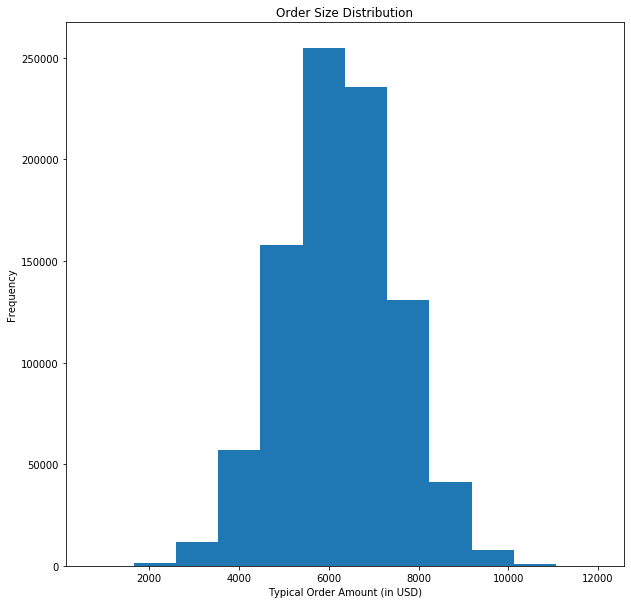

In [7]:
import matplotlib.pyplot as plt

hist=df['output.trade_volume'].plot.hist(bins=12,title="Order Size Distribution",figsize=(10,10));
hist=hist.set_xlabel("Typical Order Amount (in USD)")

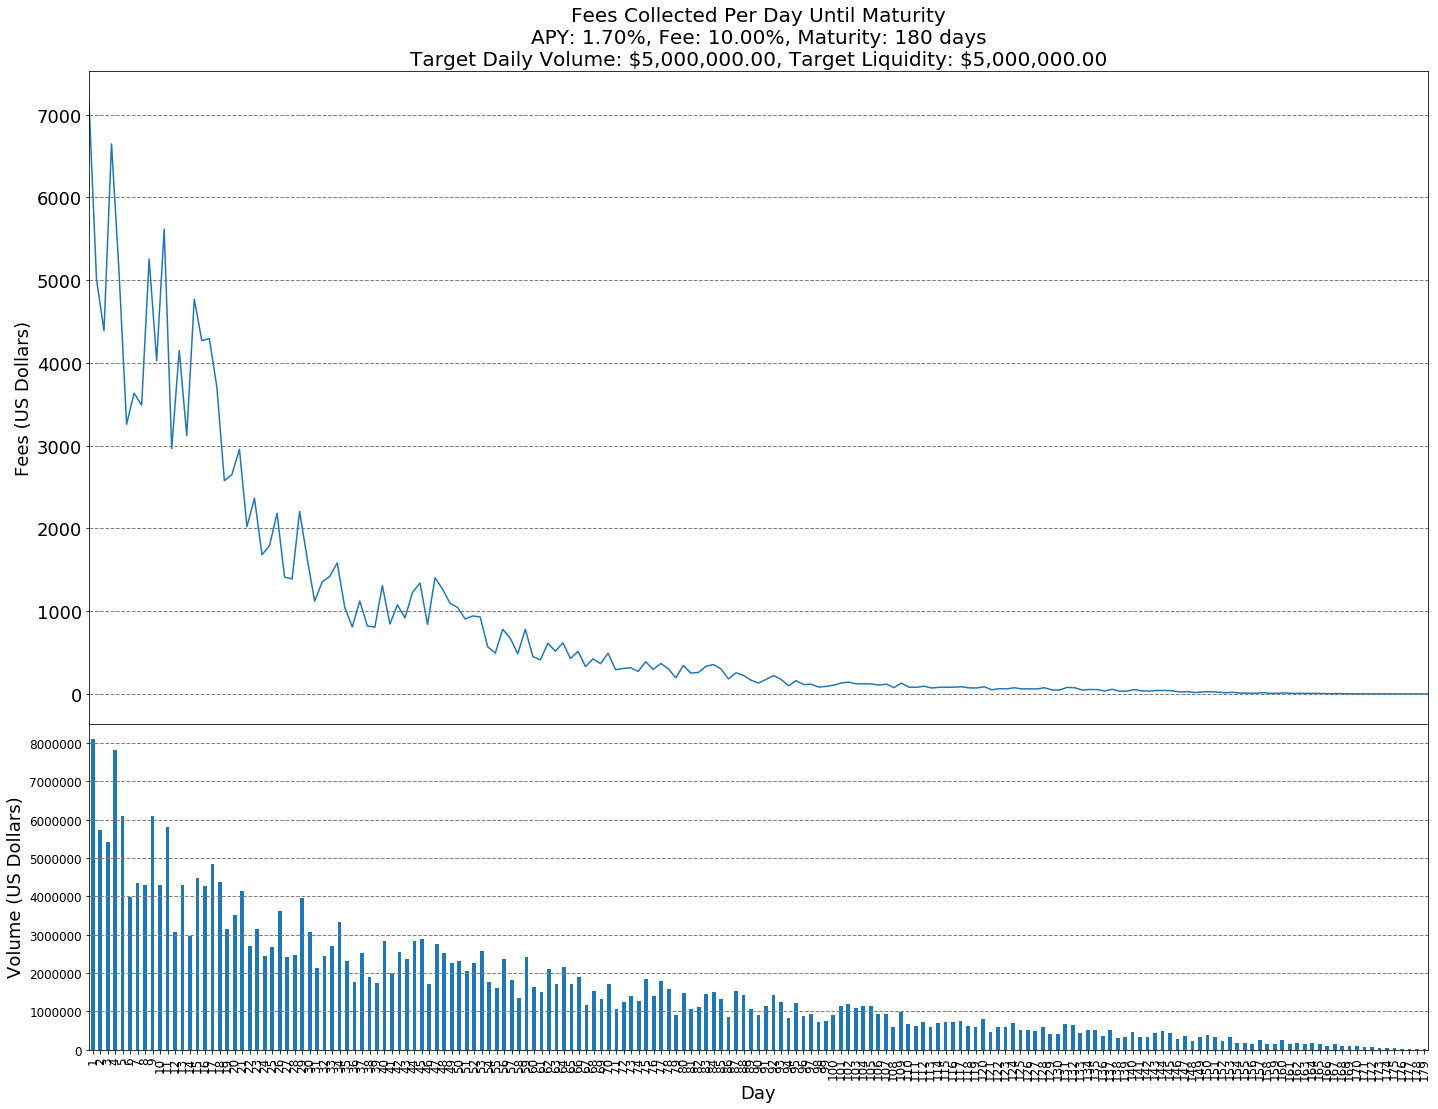

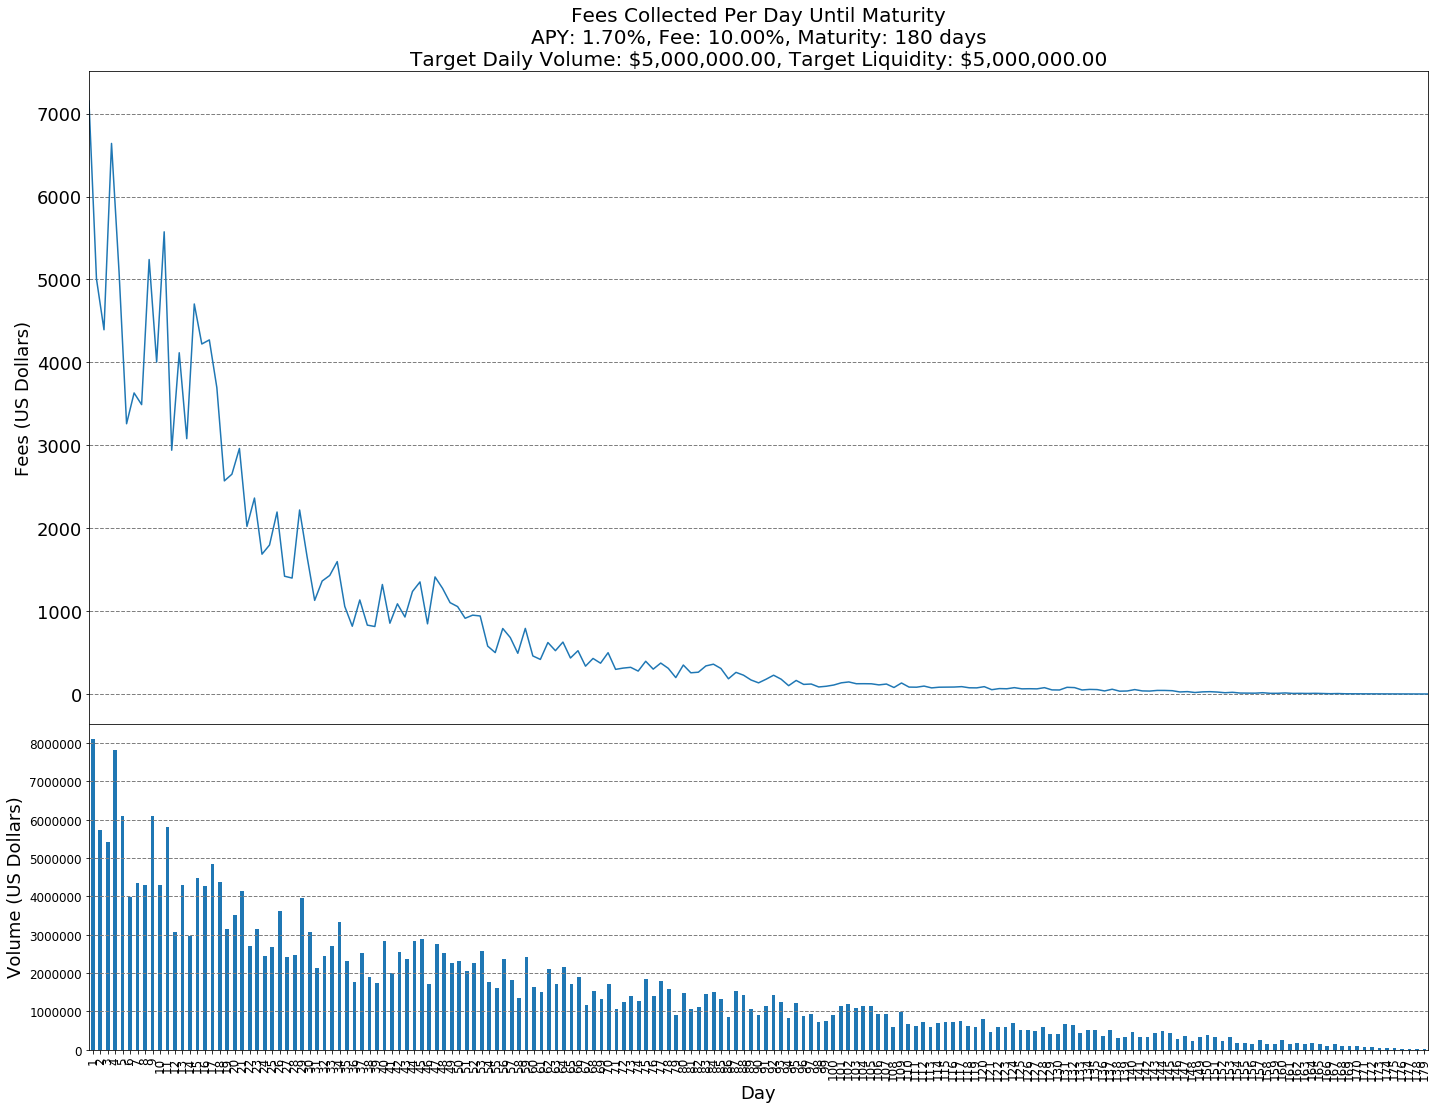

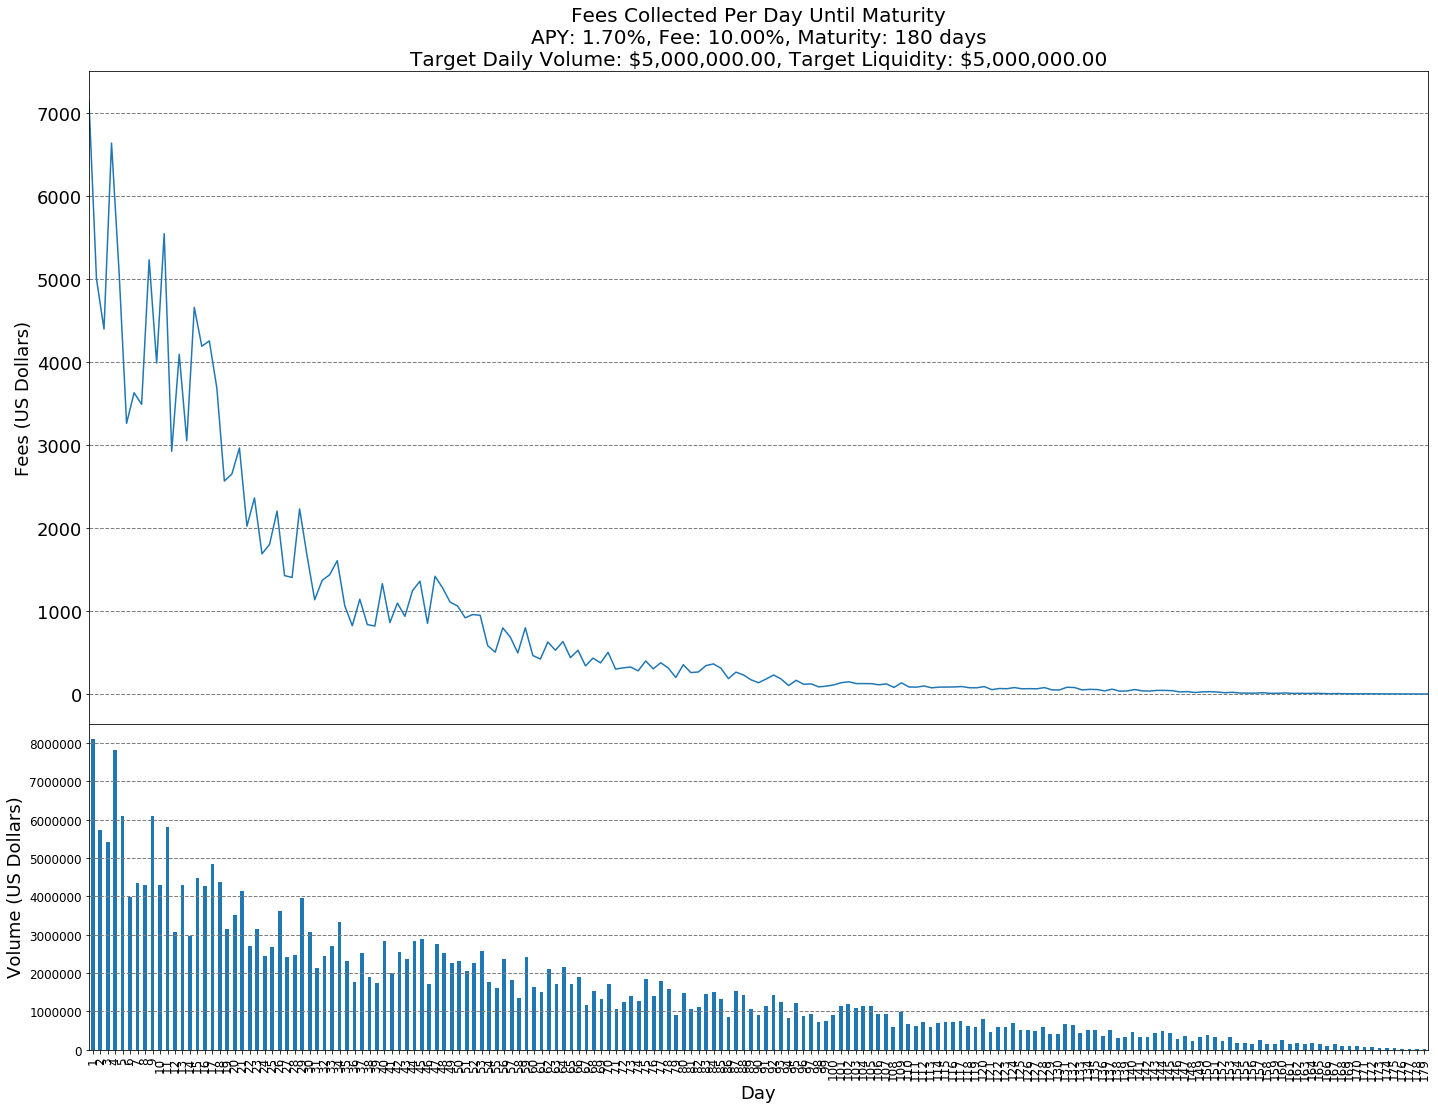

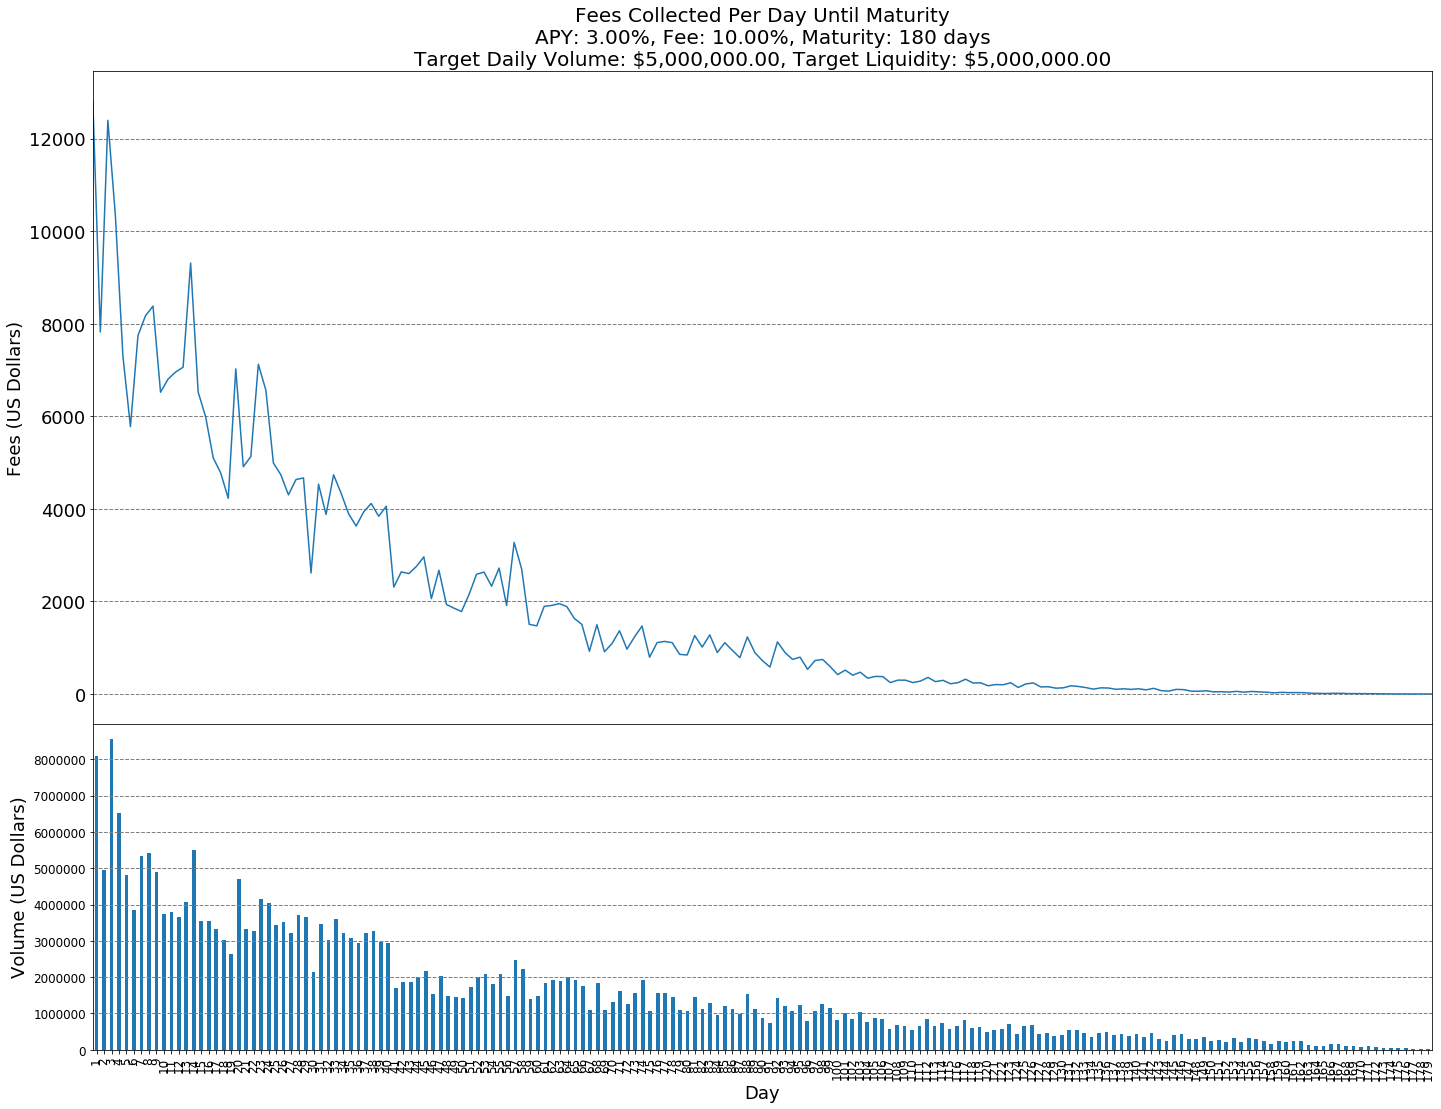

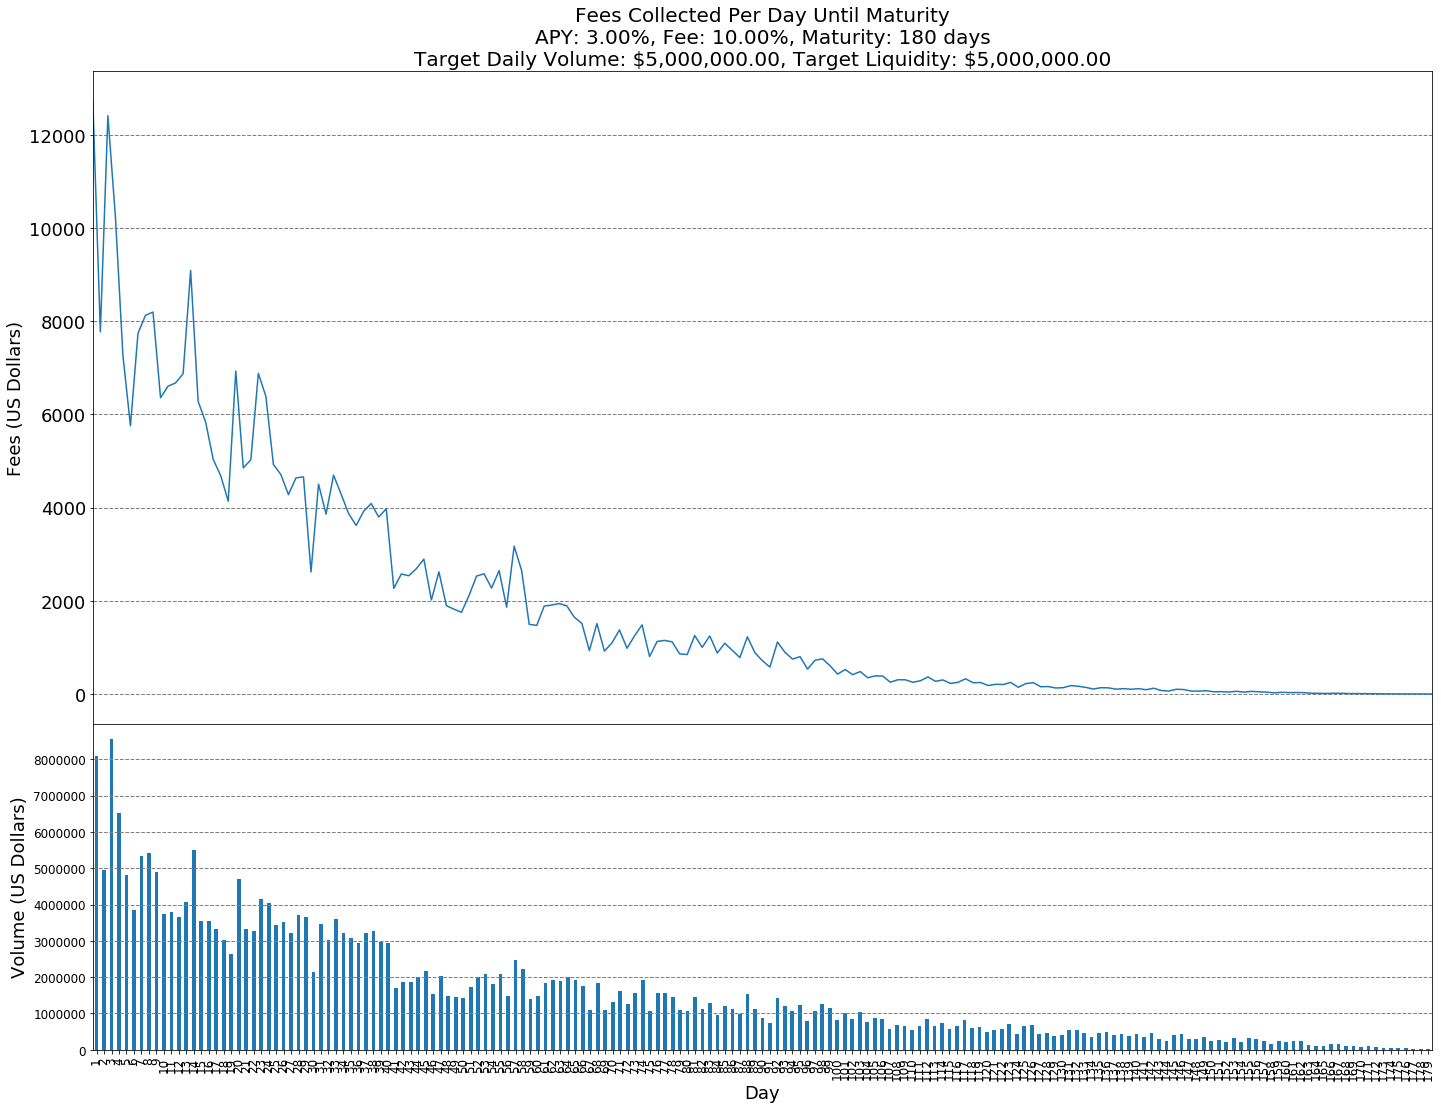

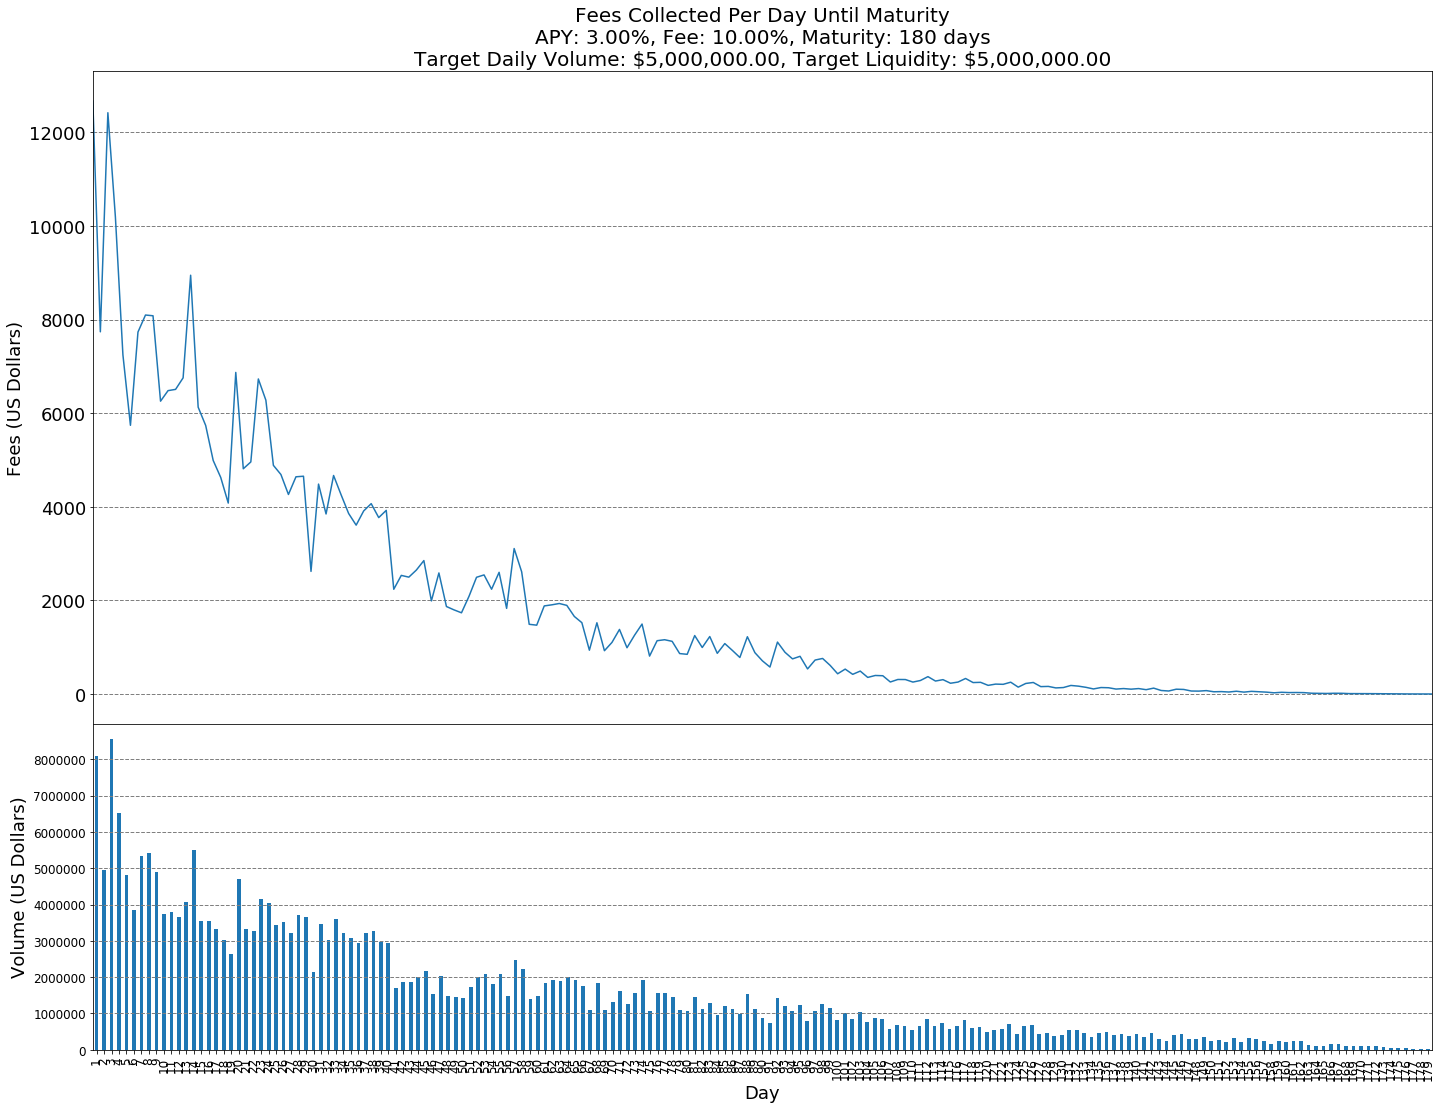

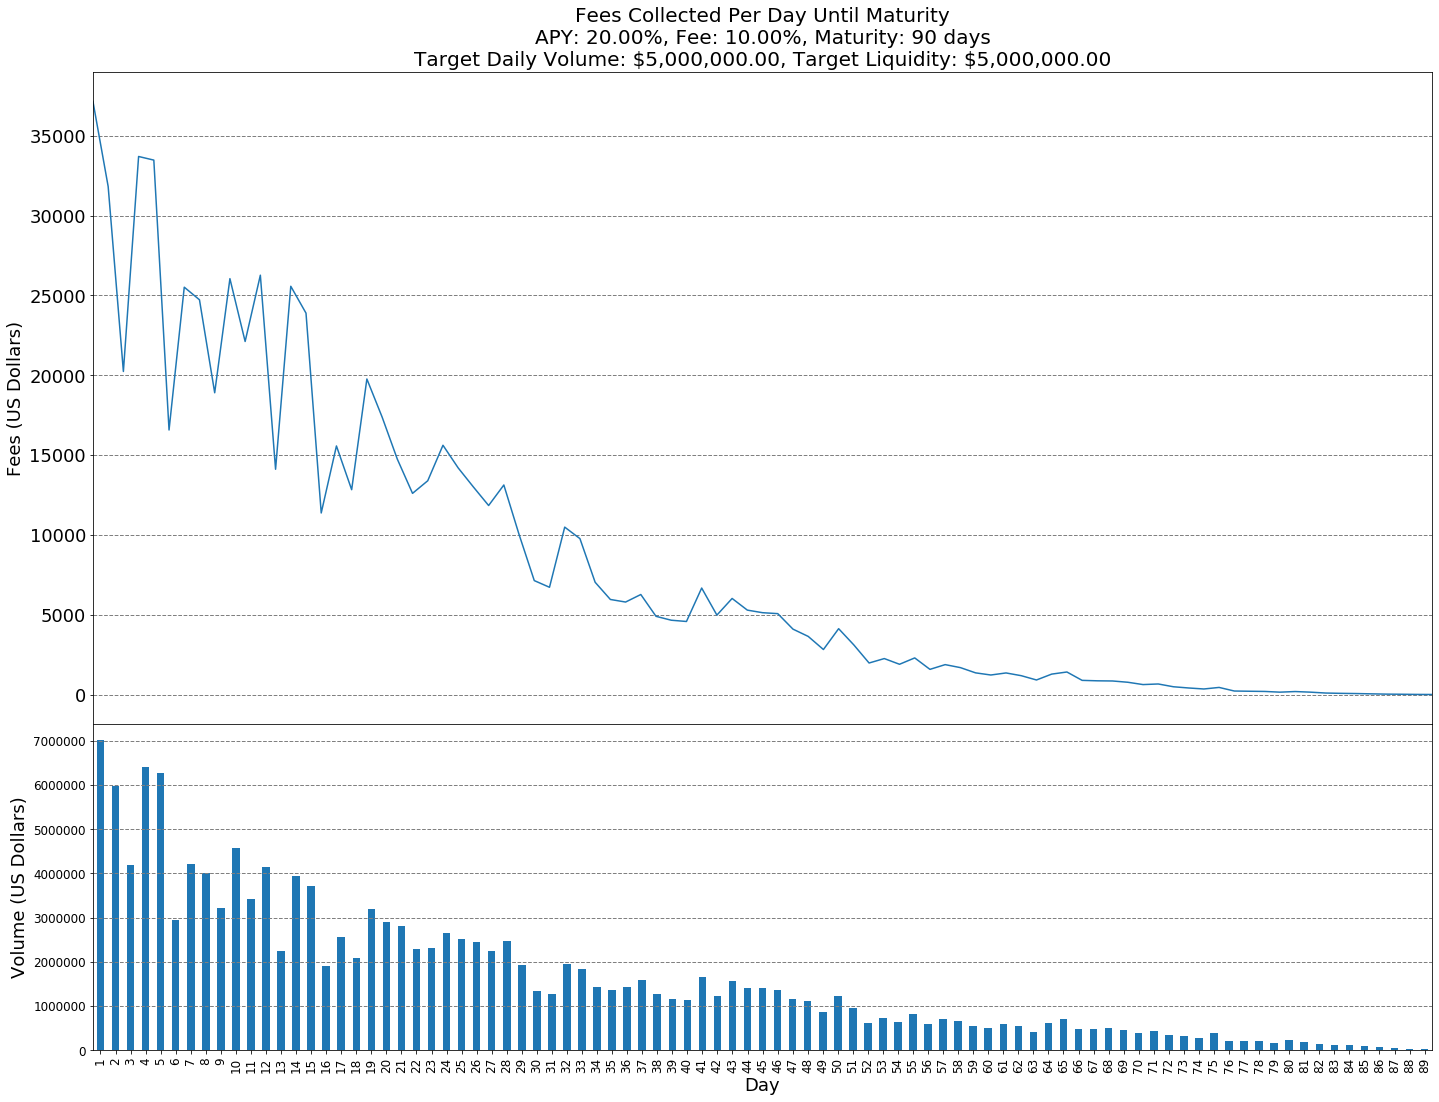

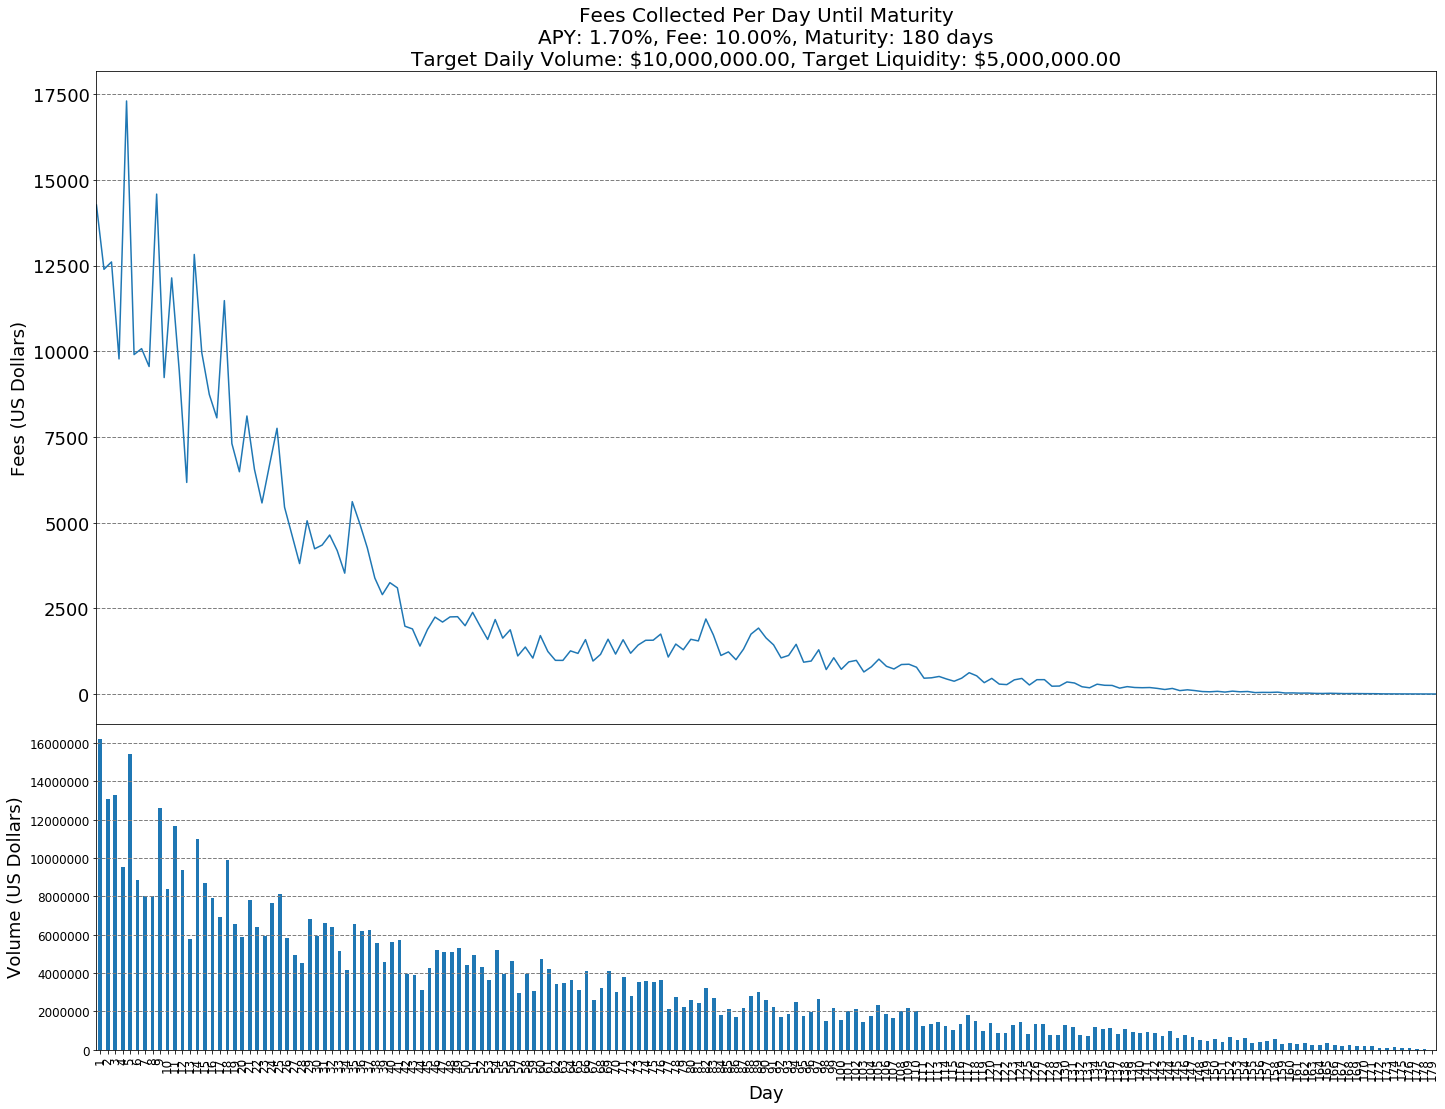

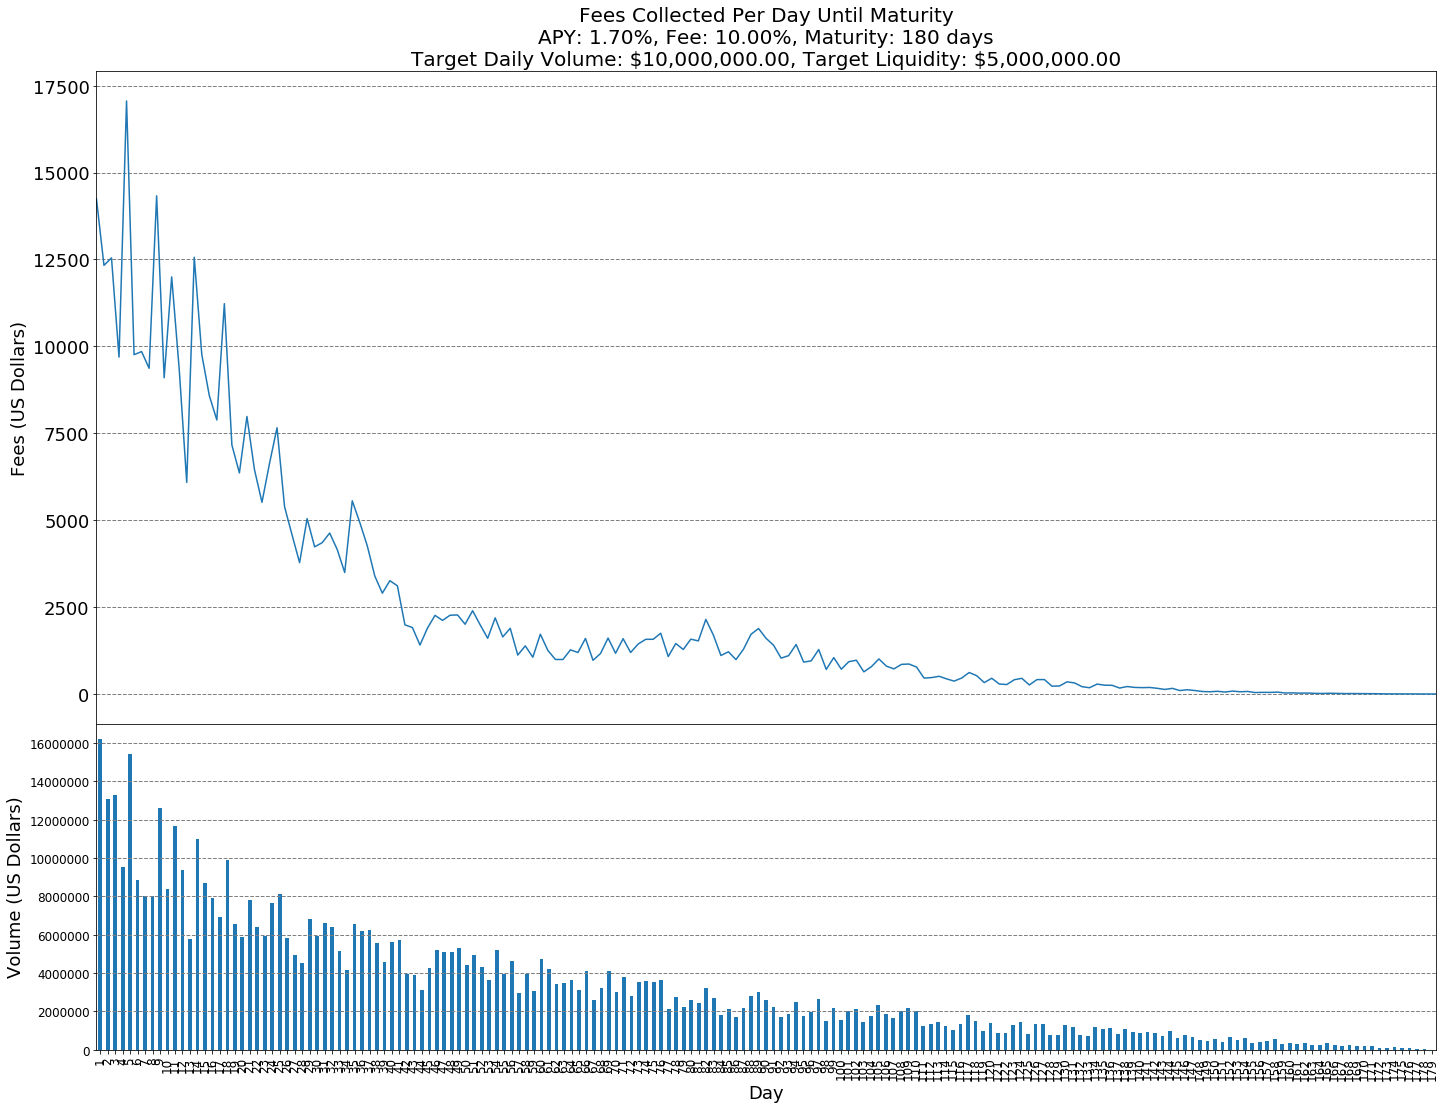

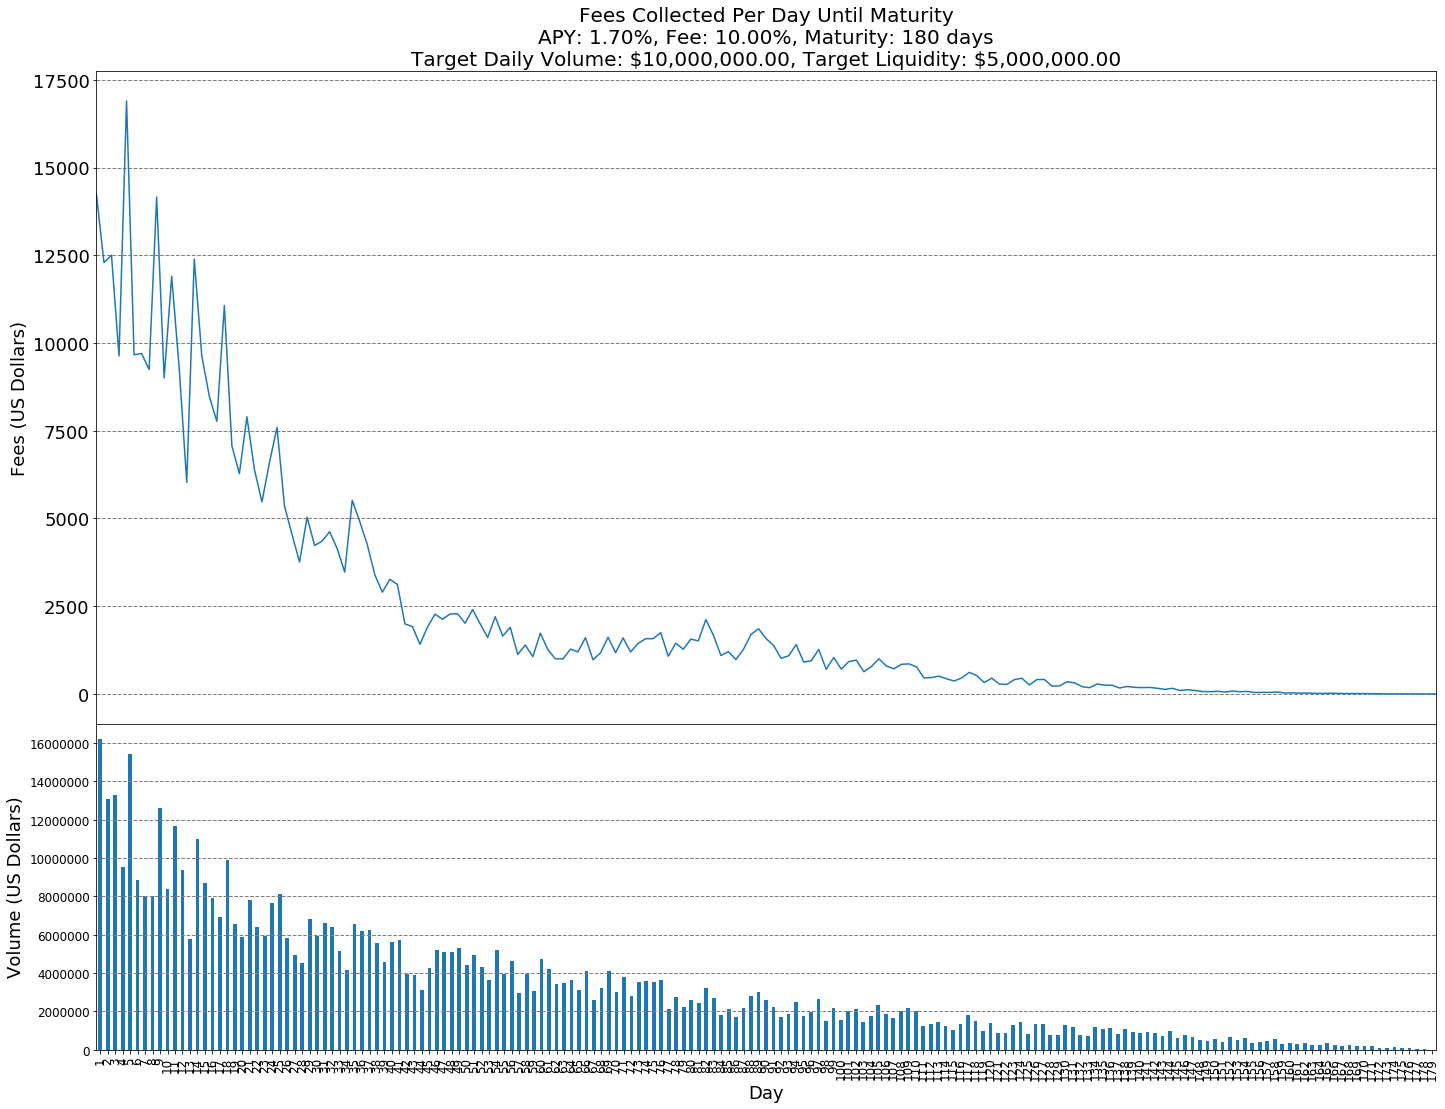

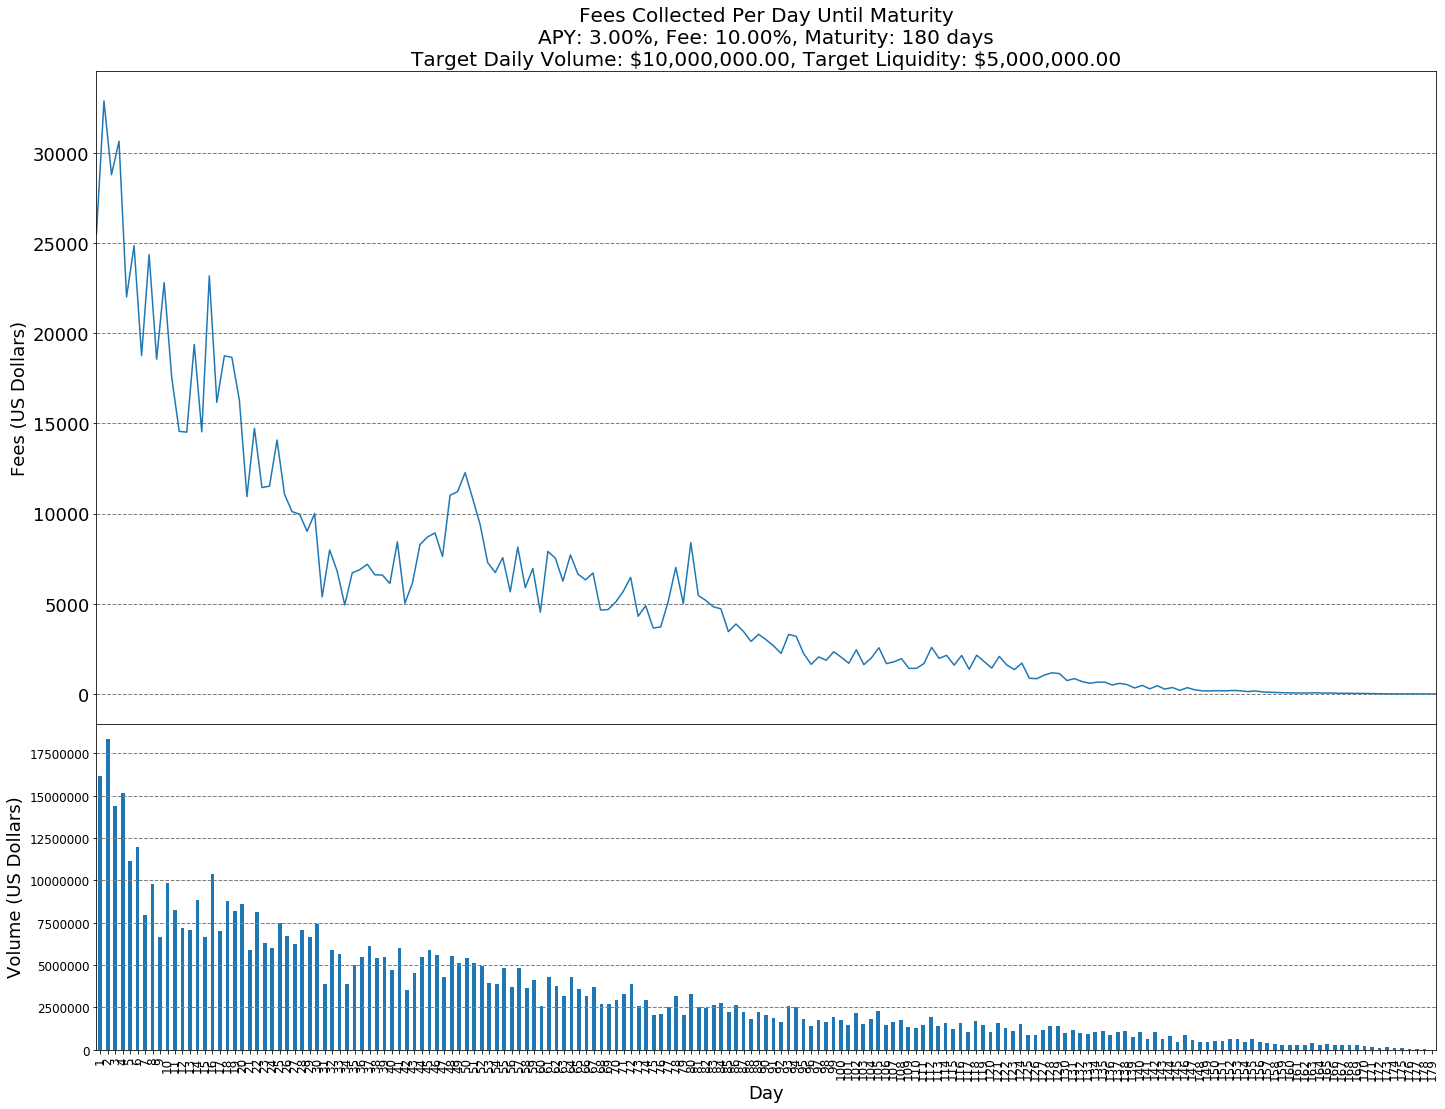

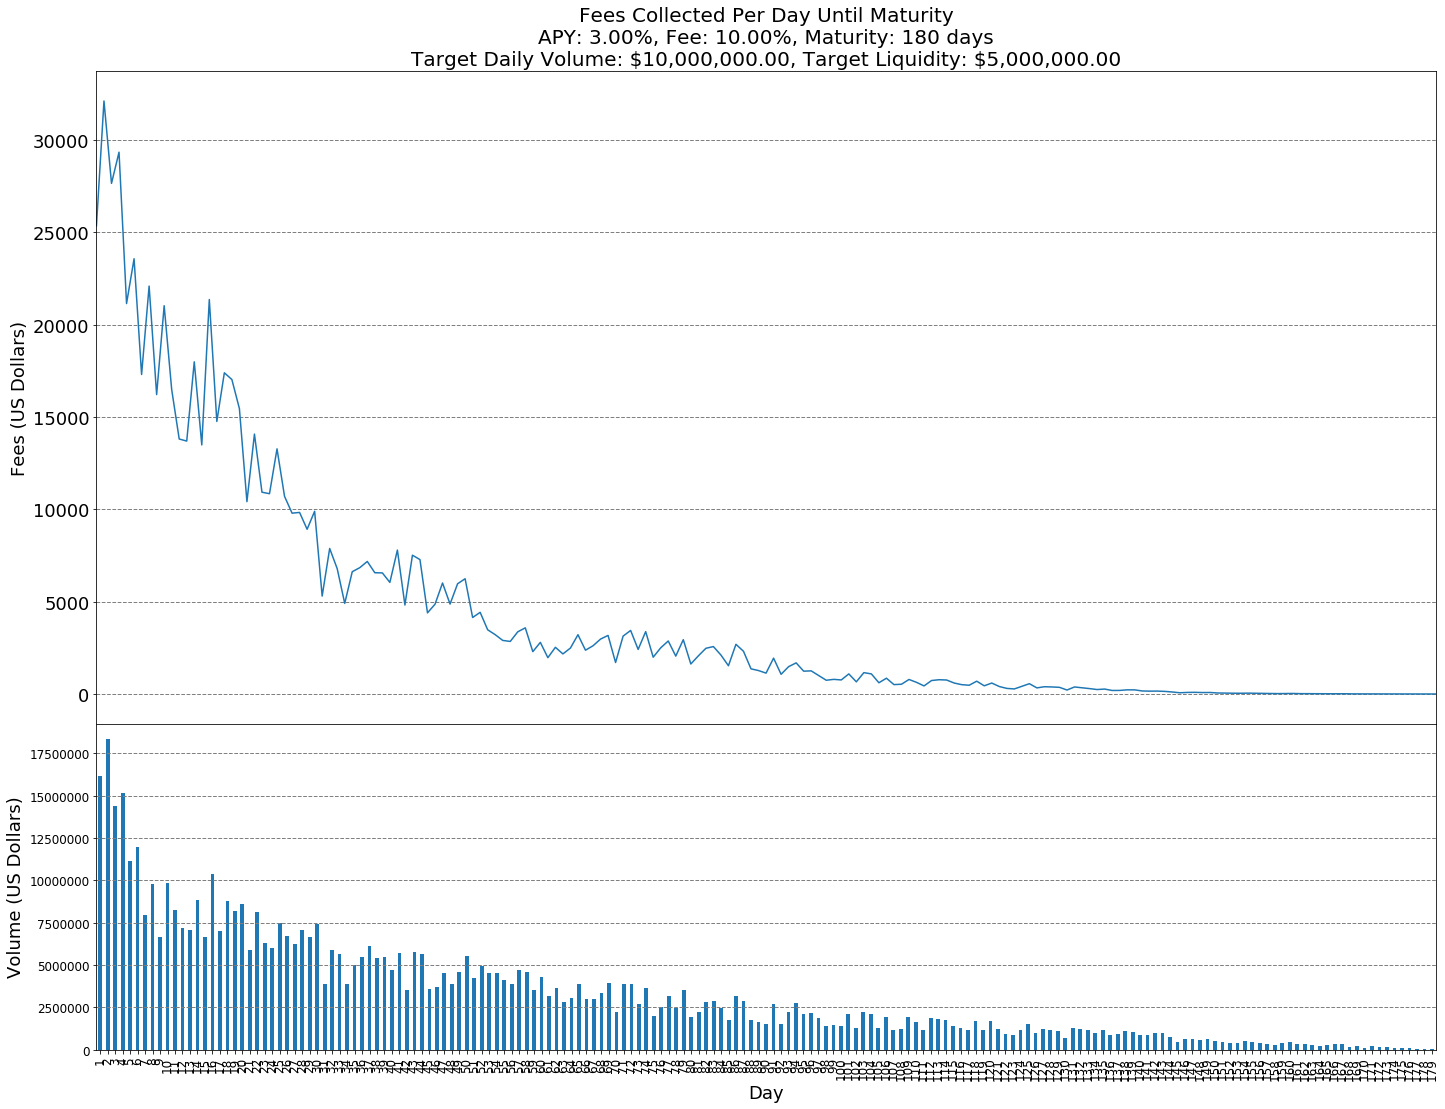

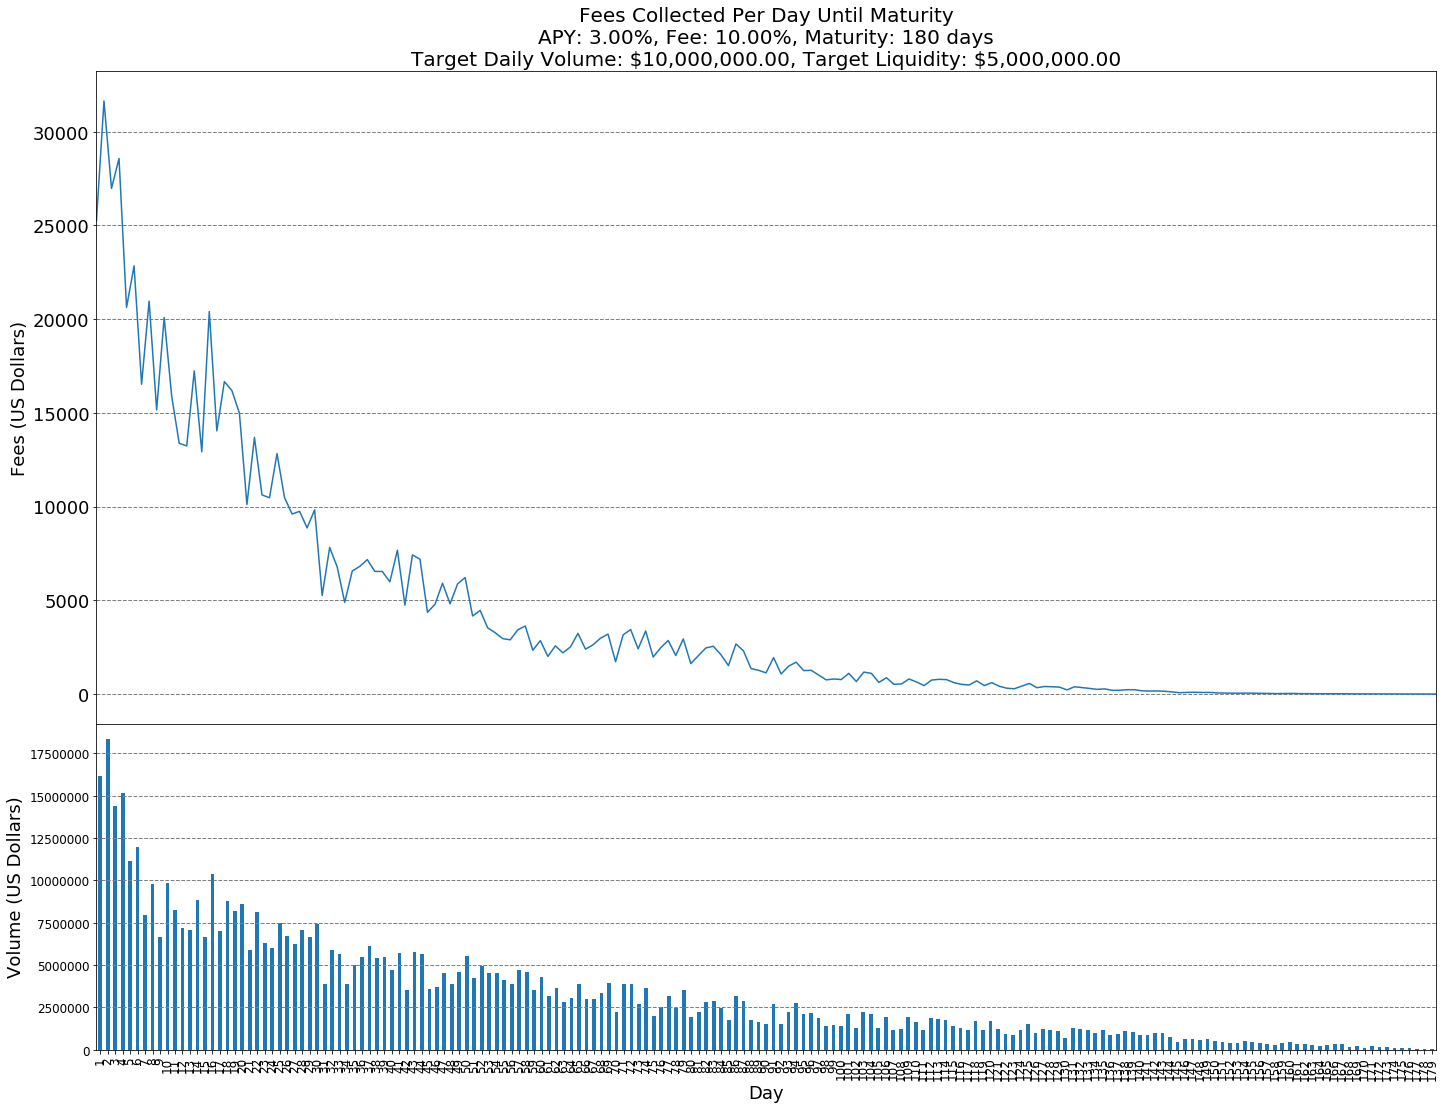

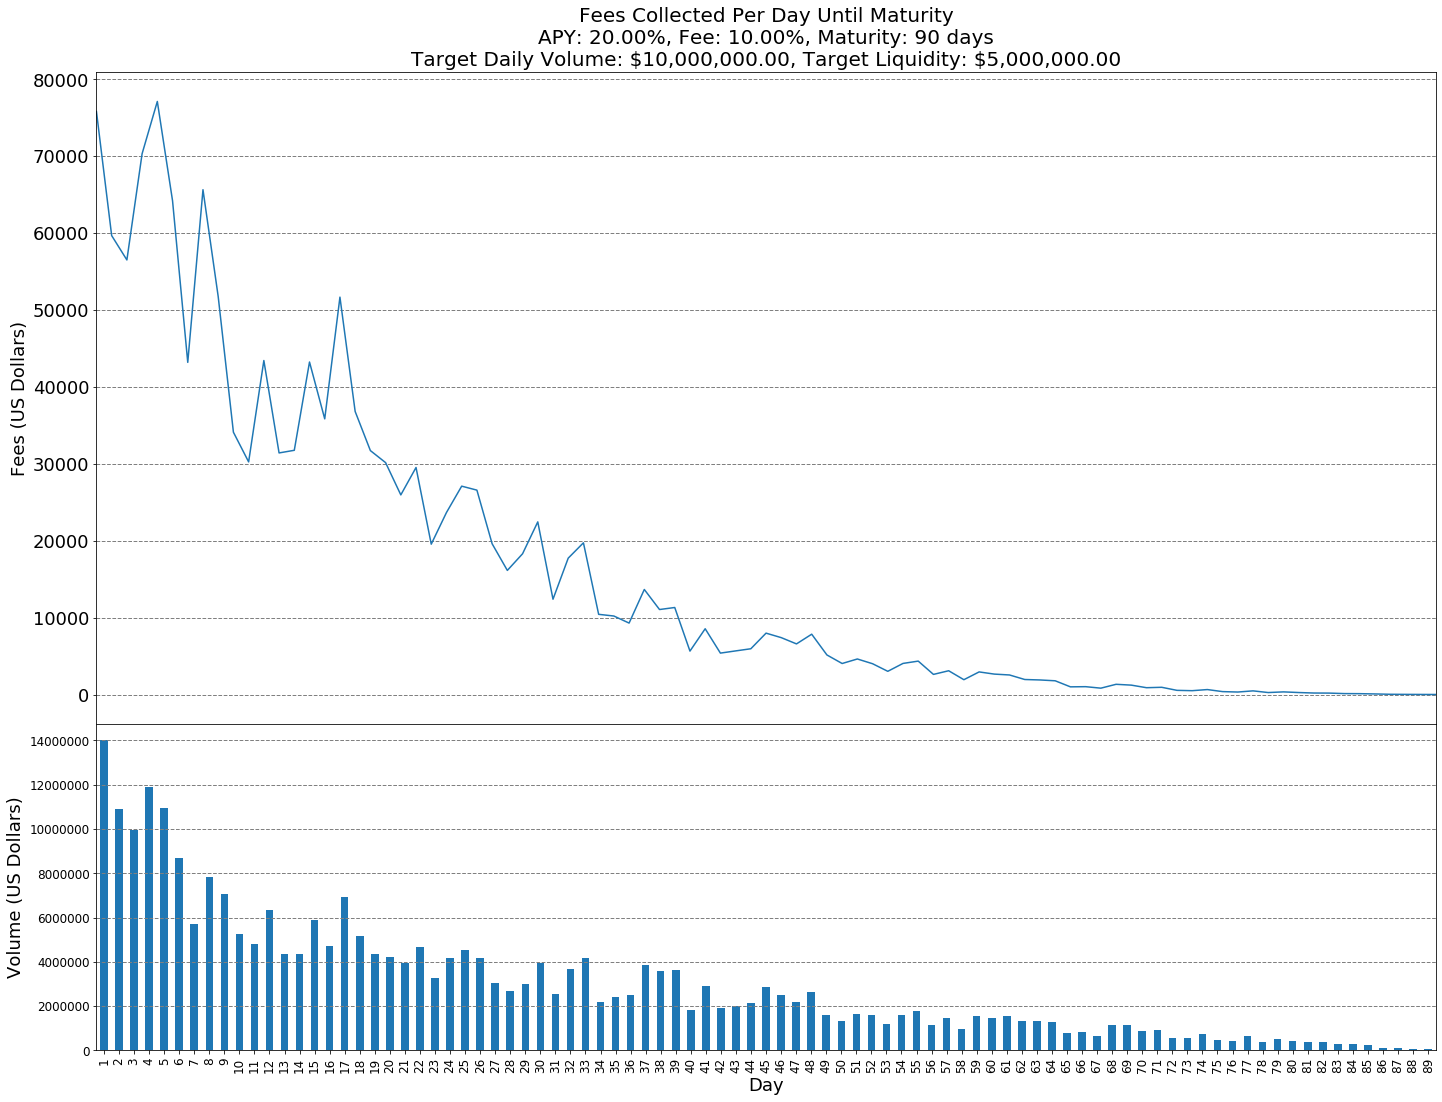

In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec

dfs=[]
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  dfs.append(df[ (df['init.market_price']==yba["market_price"]) & (df['init.time_stretch']==yba["time_stretch"]) & (df['init.apy']==yba["apy"]) & (df['init.percent_fee']==g) & (df['init.days_until_maturity']==yba["days_until_maturity"]) & (df['init.target_liquidity']==target_liquidity) & (df['init.target_daily_volume']==target_daily_volume)].reset_index())

for _df in dfs:
    fig, ax = plt.subplots(ncols=1, nrows=2,gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[2,1]})
    df_fees_volume = _df.groupby(['input.day']).agg({'output.trade_volume':['sum']\
                                   ,'output.fee':['mean','std','min','max','sum']\
                                  })
    df_fees_volume.columns = ['_'.join(col).strip() for col in df_fees_volume.columns.values]
    df_fees_volume = df_fees_volume.reset_index()
    ax[0] = df_fees_volume.plot(x="input.day", y="output.fee_sum",figsize=(24,18),ax=ax[0]);
    ax[0].set_xlabel("")
    ax[0].set_ylabel("Fees (US Dollars)",fontsize=18)
    ax[0].tick_params(axis = "both", labelsize=18)
    ax[0].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[0].xaxis.set_ticklabels([])
    title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
    ax[0].set_title(title,fontsize=20)
    ax[0].legend().set_visible(False)

    ax[1] = df_fees_volume.plot(kind='bar',x="input.day", y="output.trade_volume_sum",ax=ax[1]);
    ax[1].set_xlabel("Day",fontsize=18)
    ax[1].set_ylabel("Volume (US Dollars)",fontsize=18)
    ax[1].tick_params(axis = "both", labelsize=12)
    ax[1].grid(b=True,linestyle='--', linewidth='1', color='grey',which='both',axis='y')
    ax[1].legend().set_visible(False)
    ax[1].ticklabel_format(style='plain',axis='y')
    fig.subplots_adjust(wspace=None, hspace=None)

In [4]:
pd.options.display.float_format = '{:,.8f}'.format
df_fees_agg = df.groupby(['init.apy','init.percent_fee','init.time_stretch','init.market_price','init.target_liquidity','init.days_until_maturity','init.target_daily_volume']).agg({'output.fee':['count','sum'],'output.trade_volume':['mean','sum'],'output.slippage':['mean'],'input.amount_specified':['mean']})
df_fees_agg.columns = ['_'.join(col).strip() for col in df_fees_agg.columns.values]
df_fees_agg = df_fees_agg.reset_index()
df_fees_agg['init.percent_fee'] = df_fees_agg['init.percent_fee'].round(2)
df_fees_agg['output.mean_daily_volume'] = df_fees_agg['output.trade_volume_sum']/df_fees_agg['init.days_until_maturity']
df_fees_agg['output.apr'] = (df_fees_agg['output.fee_sum']/df_fees_agg['init.target_liquidity']) * (365/df_fees_agg['init.days_until_maturity'])*100
df_fees_agg = df_fees_agg.drop(columns=['input.amount_specified_mean','init.percent_fee']).reset_index()
df_fees_agg

,index,init.apy,init.time_stretch,init.market_price,init.target_liquidity,init.days_until_maturity,init.target_daily_volume,output.fee_count,output.fee_sum,output.trade_volume_mean,output.trade_volume_sum,output.slippage_mean,output.mean_daily_volume,output.apr
0,0,1.70000000,20,50000,5000000,180,5000000,45324,"150,719.09217444","6,242.76205624","282,946,947.43720996",-0.22474255,"1,571,927.48576228",6.11249652
1,1,1.70000000,20,50000,5000000,180,10000000,93533,"415,970.40082676","6,249.45440821","584,530,219.16281021",-0.01035493,"3,247,390.10646006",16.86991070
2,2,1.70000000,30,50000,5000000,180,5000000,45324,"150,622.23703773","6,242.76354463","282,947,014.89677542",-0.22631828,"1,571,927.86053764",6.10856850
3,3,1.70000000,30,50000,5000000,180,10000000,93533,"418,589.87638292","6,249.45905387","584,530,653.68603945",-0.01375230,"3,247,392.52047800",16.97614499
4,4,1.70000000,40,50000,5000000,180,5000000,45324,"150,504.57795092","6,242.76569394","282,947,112.31216758",-0.22859108,"1,571,928.40173426",6.10379677
5,5,1.70000000,40,50000,5000000,180,10000000,93533,"422,504.61843179","6,249.46607258","584,531,310.16636741",-0.01890321,"3,247,396.16759093",17.13490953
6,6,3.00000000,20,50000,5000000,180,5000000,45157,"335,942.20894294","6,244.35877351","281,976,509.13537735",-0.47337700,"1,566,536.16186321",13.62432292
7,7,3.00000000,20,50000,5000000,180,10000000,93687,"751,671.37249359","6,247.07380438","585,269,603.51074326",0.19788884,"3,251,497.79728191",30.48445011
8,8,3.00000000,30,50000,5000000,180,5000000,45140,"338,508.59401832","6,244.80558557","281,890,524.13272768",-0.48755846,"1,566,058.46740404",13.72840409
9,9,3.00000000,30,50000,5000000,180,10000000,93687,"767,921.81767404","6,247.10780103","585,272,788.55501902",0.18712868,"3,251,515.49197233",31.14349594


In [5]:
#df_fees_agg.to_csv("fees.csv")

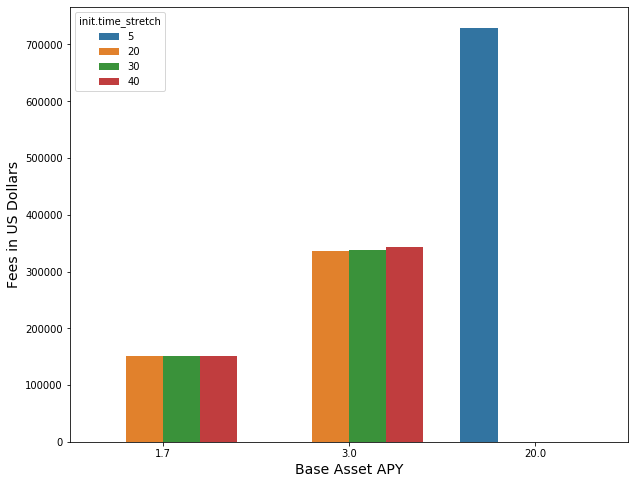

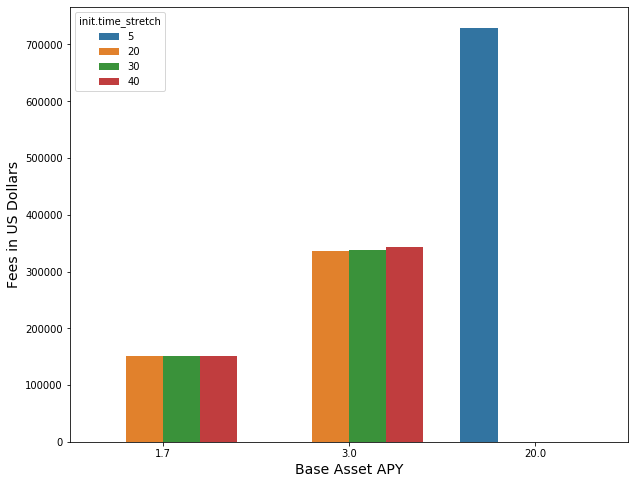

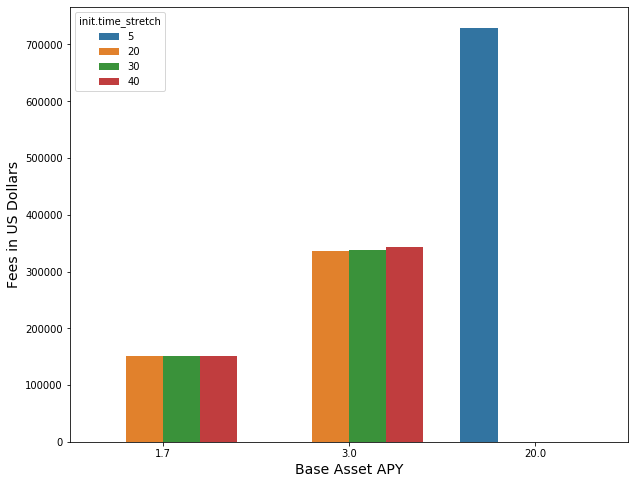

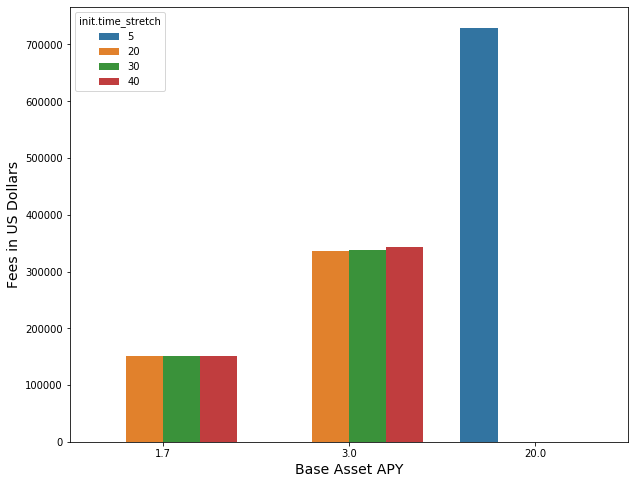

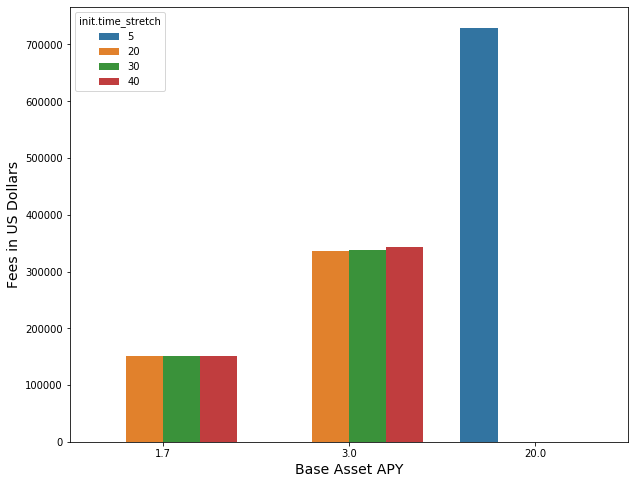

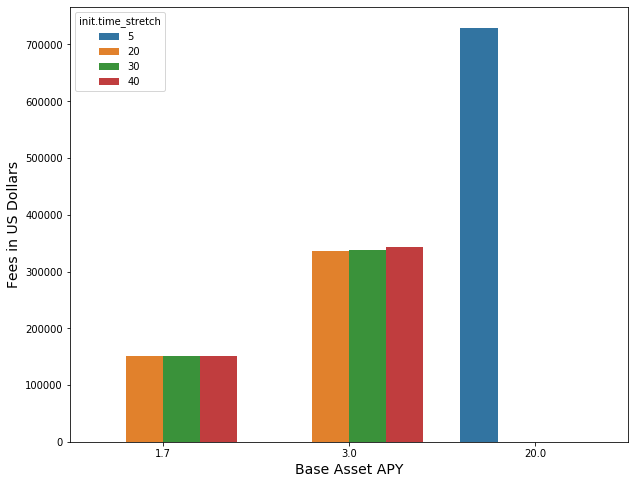

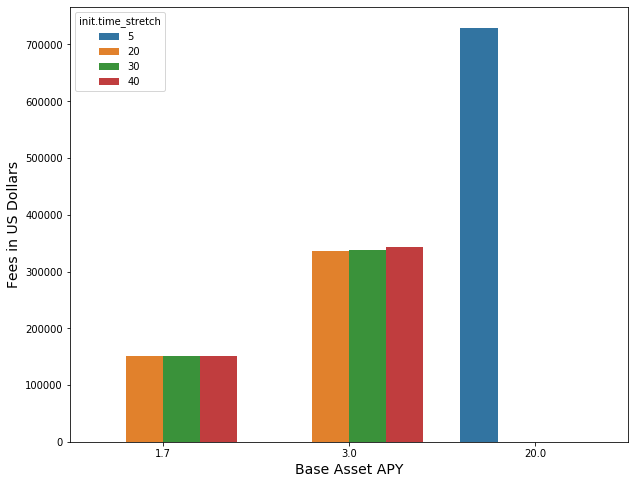

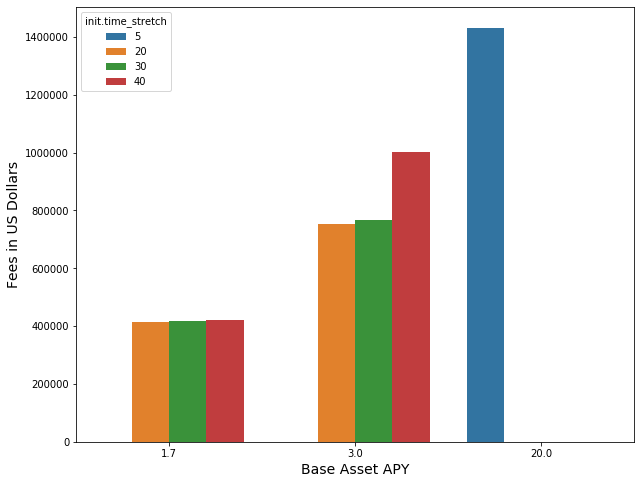

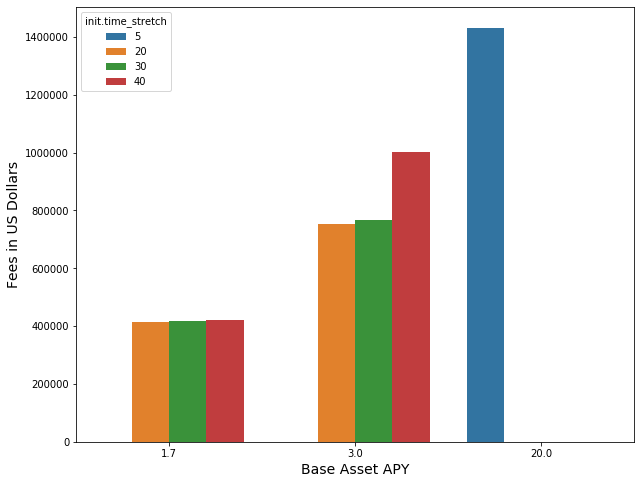

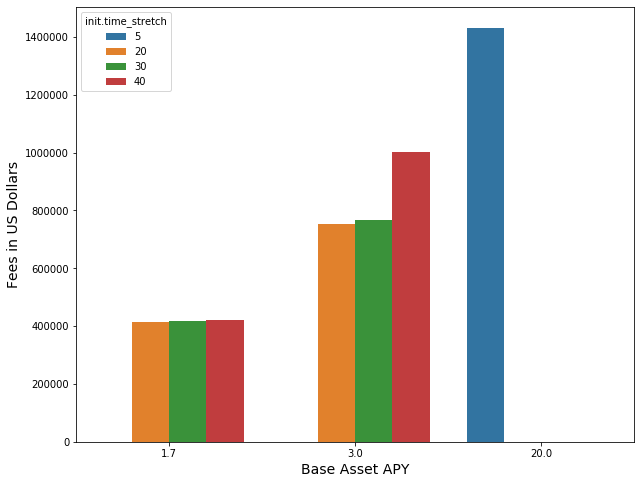

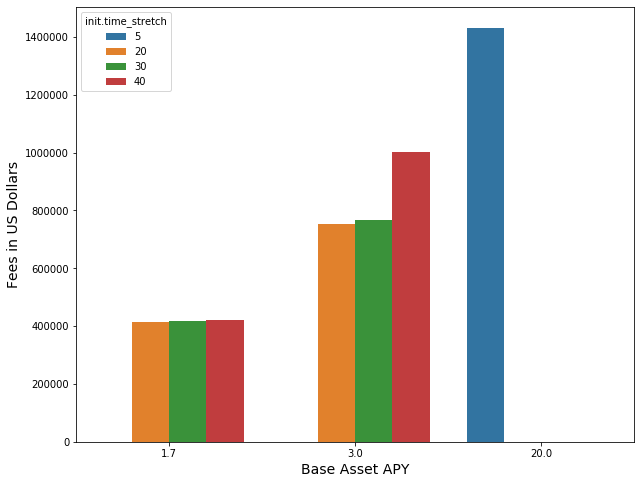

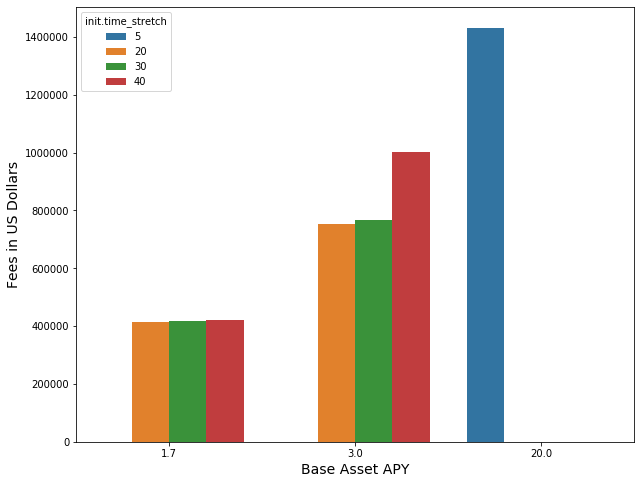

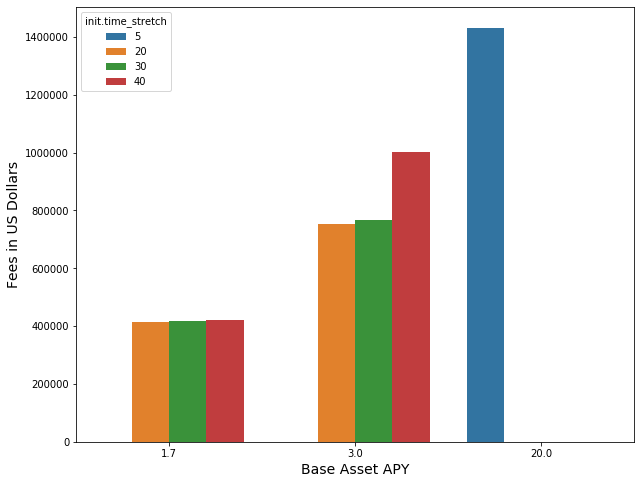

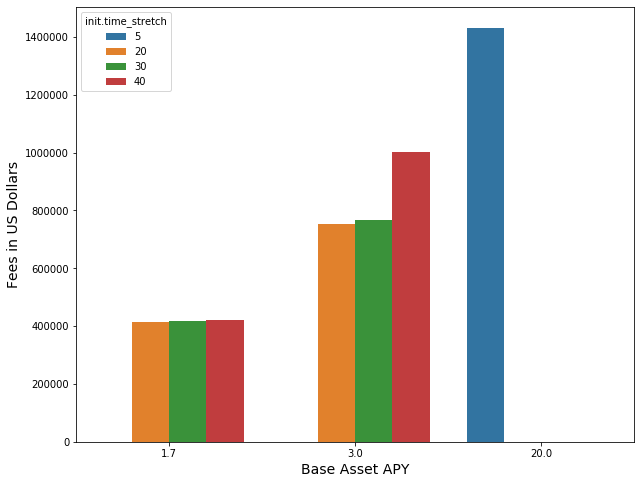

In [6]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd

#plt.figure(figsize=(20, 20))
#for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
#condition = (df_fees_agg['init.market_price']==yba["market_price"]) & (df_fees_agg['init.days_until_maturity']==yba["days_until_maturity"]) & (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
for (yba,g,target_liquidity,target_daily_volume) in run_matrix:
  plt.figure(figsize=(10, 8))
  condition =   (df_fees_agg['init.target_liquidity']==target_liquidity) & (df_fees_agg['init.target_daily_volume']==target_daily_volume)
  sns.barplot(x="init.apy", 
              y="output.fee_sum", 
              hue="init.time_stretch", 
              data=df_fees_agg[condition],
              ci=None)
  plt.ticklabel_format(style='plain',axis='y')
  plt.ylabel("Fees in US Dollars", size=14)
  plt.xlabel("Base Asset APY", size=14)
  #title = "Fees Collected Per Day Until Maturity\nAPY: {:.2f}%, Fee: {:.2f}%, Maturity: {:} days\nTarget Daily Volume: \${:,.2f}, Target Liquidity: \${:,.2f}".format(_df['init.apy'][0],_df['init.percent_fee'][0]*100,_df['init.days_until_maturity'][0],_df['init.target_daily_volume'][0],_df['init.target_liquidity'][0])
  #plt.title("Cumulative Fees for 30 day FYT\n"+"Target Volume = " + str(df_fees_agg[condition]['init.target_daily_volume'].iloc[0]) + "\nTarget Liquidity = " + str(df_fees_agg[condition]['init.target_liquidity'].iloc[0]), size=14)
